In [237]:
import os
import requests
from bs4 import BeautifulSoup
import textwrap
import pandas as pd
import lxml  
import time
from IPython.display import clear_output
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import sleep
import re
from tqdm import tqdm
from functools import reduce

# Web-scrapped data loading

In [238]:
raw_data = pd.read_csv('notebooks.csv', encoding = 'utf-16', index_col = 0)
raw_data

,CrossFire/SLI-массив,SSHD накопитель (объем SSD буфера),average_rating,price,reviews_num,Автоматическое увеличение частоты,Архитектура процессора,Аудио интерфейсы,Беспроводные виды доступа в Интернет,Веб-камера,...,Цветовой охват,Цифровой блок клавиатуры,Частота,Частота оперативной памяти,Ширина,Год релиза,Количество слотов под модули памяти,"Особенности, дополнительно",Скорость сетевого адаптера,Технология динамического обновления экрана
0,нет,нет,1.0,17999.0,1.0,2.2 ГГц,GoldMont,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,"49% sRGB, 45% NTSC, 34% AdobeRGB",нет,1.1 ГГц,2133 МГц,268 мм,NaN,NaN,NaN,NaN,NaN
1,нет,нет,4.2,24999.0,17.0,2.8 ГГц,Goldmont Plus,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,45% NTSC,есть,1.1 ГГц,2400 МГц,279 мм,2020.0,интегрирована,NumberPad,нет,нет
2,нет,нет,4.7,24999.0,3.0,2.8 ГГц,Goldmont Plus,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,45% NTSC,есть,1.1 ГГц,2400 МГц,279 мм,2020.0,интегрирована,NumberPad,нет,нет
3,нет,нет,4.6,24999.0,9.0,2.8 ГГц,Goldmont Plus,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,45% NTSC,нет,1.1 ГГц,2133 МГц,279 мм,2020.0,интегрирована,NumberPad,нет,нет
4,нет,нет,3.8,28999.0,9.0,2.6 ГГц,Excavator,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,NaN,есть,2.3 ГГц,1866 МГц,381 мм,2020.0,1,NaN,нет,нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,нет,нет,NaN,313999.0,NaN,4.5 ГГц,Comet Lake,"3.5 мм jack (наушники), 3.5 мм jack (микрофонный)",Wi-Fi,есть,...,100% AdobeRGB,нет,2.6 ГГц,2666 МГц,358.5 мм,2020.0,2,NaN,1000 Мбит,нет
725,нет,нет,3.0,349999.0,2.0,4.5 ГГц,Comet Lake,"3.5 мм jack (наушники), 3.5 мм jack (микрофонный)",Wi-Fi,есть,...,100% AdobeRGB,нет,2.6 ГГц,2666 МГц,358.5 мм,2020.0,2,NaN,1000 Мбит,нет
726,нет,нет,NaN,379999.0,NaN,5 ГГц,Comet Lake,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,100% AdobeRGB,нет,2.6 ГГц,2933 МГц,358.5 мм,2020.0,2,NaN,1000 Мбит,нет
727,нет,нет,NaN,380999.0,NaN,4.5 ГГц,Comet Lake,"3.5 мм jack (наушники), 3.5 мм jack (микрофонный)",Wi-Fi,есть,...,100% AdobeRGB,нет,2.6 ГГц,2666 МГц,358.5 мм,2020.0,2,NaN,1000 Мбит,нет


In [239]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 0 to 728
Data columns (total 85 columns):
CrossFire/SLI-массив                              729 non-null object
SSHD накопитель (объем SSD буфера)                729 non-null object
average_rating                                    463 non-null float64
price                                             729 non-null float64
reviews_num                                       463 non-null float64
Автоматическое увеличение частоты                 727 non-null object
Архитектура процессора                            724 non-null object
Аудио интерфейсы                                  707 non-null object
Беспроводные виды доступа в Интернет              729 non-null object
Веб-камера                                        694 non-null object
Вес                                               718 non-null object
Вид графического ускорителя                       729 non-null object
Вид сетевого адаптера (Ethernet)                  72

# Data preparation

Firstly, let us rename columns in the same concise way

In [240]:
rename_cols_dict = {
        'CrossFire/SLI-массив': 'crossfire_sli',
        'SSHD накопитель (объем SSD буфера)': 'sshd_capacity',
        'average_rating': 'average_rating',
#         'brand_name': 'brand_name', 
#         'model_name': 'model_name', 
        'price': 'price', 
        'reviews_num': 'reviews_num',
        'Автоматическое увеличение частоты': 'max_cpu_frequency',
        'Архитектура процессора': 'cpu_architecture',
        'Аудио интерфейсы': 'audio_interfaces', 
        'Беспроводные виды доступа в Интернет': 'internet_connections',
        'Веб-камера': 'web_camera',
        'Вес': 'weight',
        'Вид графического ускорителя': 'graphics_device',
        'Вид сетевого адаптера (Ethernet)': 'ethernet_adapter',
        'Видео интерфейсы': 'video_interfaces',
        'Время отклика пикселя, мс': 'pixel_response_time', 
        'Встроенный микрофон': 'microphone', 
        'Гарантия': 'warranty_duration',
        'Глубина': 'depth', 
        'Диагональ экрана (дюйм)': 'screen_diagonal', 
        'Дополнительные интерфейсы': 'additional_interfaces',
        'Емкость аккумулятора': 'battery_capacity', 
        'Игровой ноутбук': 'gaming_laptop', 
        'Кенсингтонский замок': 'kensington_lock',
        'Код производителя': 'producer_code', 
        'Количество ядер процессора': 'cpu_cores_num', 
        'Комплектация': 'package',
        'Конструктивное исполнение': 'design', 
        'Конфигурация накопителей': 'storage_type', 
        'Кэш L2': 'l2_cache',
        'Кэш L3': 'l3_cache', 
        'Линейка процессора': 'cpu_family',
        'Максимальная частота обновления экрана': 'screen_refresh_rate', 
        'Максимальное число потоков': 'threads_num',
        'Максимальный объем памяти': 'max_possible_ram', 
        'Материал корпуса': 'case_material',
        'Модель': 'model_full_name',
        'Модель встроенной видеокарты': 'integrated_graphics_card_model', 
        'Модель дискретной видеокарты': 'dedicated_graphics_card_model',
        'Модель процессора': 'cpu_model', 
        'Название формата': 'screen_resolution_name',
        'Общий объем жестких дисков (HDD)': 'hdd_capacity',
        'Общий объем твердотельных накопителей (SSD)': 'ssd_capacity', 
        'Объем видеопамяти': 'graphics_ram',
        'Объем накопителя Intel Optane': 'intel_optane_drive_capacity', 
        'Операционная система': 'os',
        'Оптический привод': 'optical_disc_drive', 
        'Плотность пикселей': 'ppi',
        'Поддержка USB Power Delivery': 'usb_power_delivery',
        'Поддержка дополнительных видов передачи данных': 'additional_data_transfer_methods',
        'Поддержка карт памяти кард-ридером': 'supported_memory_card', 
        'Подсветка клавиш': 'keyboard_backlight',
        'Покрытие экрана': 'screen_coating', 
        'Порты USB 2.0': 'usb_2_0_ports', 
        'Порты USB 3.х': 'usb_3_x_ports', 
        'Порты USB Type-C': 'usb_type_c_ports',
        'Приблизительное время автономной работы': 'estimated_battery_life', 
        'Производитель видеочипа': 'gpu_manufacturer',
        'Производитель процессора': 'cpu_manufacturer', 
        'Размер оперативной памяти': 'ram',
        'Разрешение экрана': 'screen_resolution', 
        'Разъем M.2': 'M_2_connector', 
        'Расширенная акустическая система': 'sound_system',
        'Сенсорный экран': 'touch_screen', 
        'Сканер отпечатка пальца': 'fingerprint_scanner',
        'Скорость вращения шпинделя': 'hdd_rpm', 
        'Стандарт Wi-Fi': 'wi_fi_standard', 
        'Страна-производитель': 'manufacturer_country',
        'Технологический процесс': 'cpu_lithography', 
        'Тип аккумулятора': 'battery_type', 
        'Тип видеопамяти': 'graphics_ram_type',
        'Тип оперативной памяти': 'ram_type', 
        'Тип устройства': 'device_type', 
        'Тип экрана': 'display_type', 
        'Толщина': 'height',
        'Цвет верхней крышки': 'color', 
        'Цветовой охват': 'color_gamut', 
        'Цифровой блок клавиатуры': 'numeric_keypad',
        'Частота': 'cpu_frequency', 
        'Частота оперативной памяти': 'ram_frequency', 
        'Ширина': 'width', 
        'Год релиза': 'release_year',
        'Количество слотов под модули памяти': 'memory_slots_num', 
        'Особенности, дополнительно': 'additional_info',
        'Скорость сетевого адаптера': 'ethernet_adapter_speed',
        'Технология динамического обновления экрана': 'adaptive_sync_technology'
    }

raw_data.columns = [rename_cols_dict[col_name] for col_name in raw_data.columns]

In [241]:
# raw_data[['model_full_name', 'producer_code']]

In [242]:
raw_data.head(1)

,crossfire_sli,sshd_capacity,average_rating,price,reviews_num,max_cpu_frequency,cpu_architecture,audio_interfaces,internet_connections,web_camera,...,color_gamut,numeric_keypad,cpu_frequency,ram_frequency,width,release_year,memory_slots_num,additional_info,ethernet_adapter_speed,adaptive_sync_technology
0,нет,нет,1.0,17999.0,1.0,2.2 ГГц,GoldMont,3.5 мм jack (микрофон/аудио),Wi-Fi,есть,...,"49% sRGB, 45% NTSC, 34% AdobeRGB",нет,1.1 ГГц,2133 МГц,268 мм,NaN,NaN,NaN,NaN,NaN


# Overall data analysis

In [243]:
def print_whole_df(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
        print(df)

# Column-by-column processing

In [244]:
columns = raw_data.columns

In [245]:
def col_info(idx = 0, columns = columns, col_name = None):
    if col_name is None:
        col_name = columns[idx]
        
    print(f'col_name = {col_name}')
    print(f'col_dtype = {raw_data[col_name].dtype}\n')
    print('unique_values_counts:\n')
    print(raw_data[col_name].value_counts(dropna = False))

In [246]:
col_info(0)

col_name = crossfire_sli
col_dtype = object

unique_values_counts:

нет    729
Name: crossfire_sli, dtype: int64


In [247]:
col_info(0)

col_name = crossfire_sli
col_dtype = object

unique_values_counts:

нет    729
Name: crossfire_sli, dtype: int64


In [248]:
raw_data.drop('crossfire_sli', axis = 1, inplace = True, errors = 'ignore')

In [249]:
col_info(1)

col_name = sshd_capacity
col_dtype = object

unique_values_counts:

нет    729
Name: sshd_capacity, dtype: int64


In [250]:
raw_data.drop('sshd_capacity', axis = 1, inplace = True, errors = 'ignore')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000201884FBD30>,
      dtype=object)

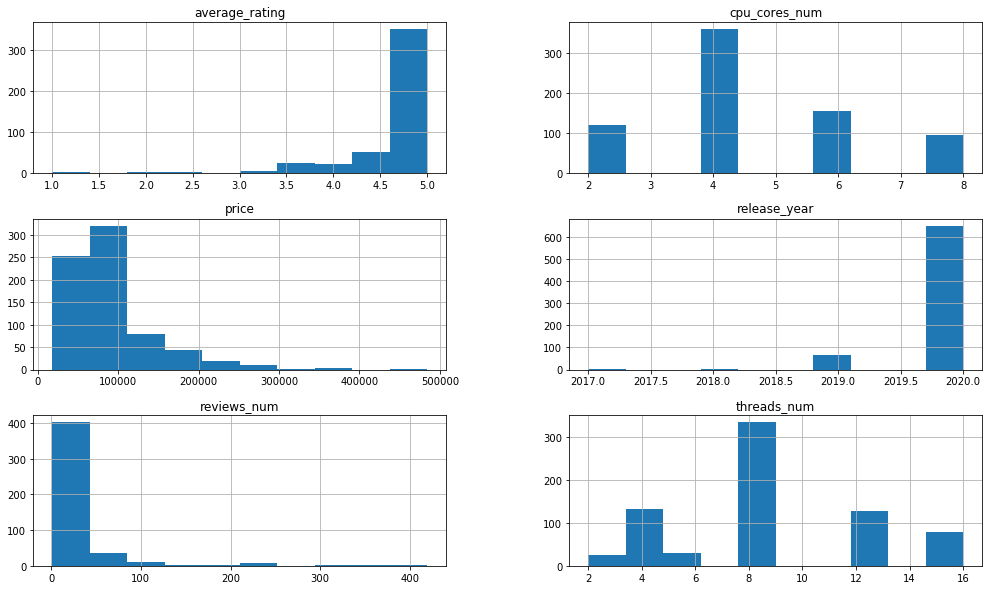

In [251]:
raw_data.hist(figsize = (17, 10))

In [252]:
col_info(2)

col_name = average_rating
col_dtype = float64

unique_values_counts:

NaN    266
5.0    184
4.8     53
4.7     44
4.6     44
4.9     26
4.5     23
4.0     15
4.4     14
4.3     11
3.8     11
3.7      9
4.1      7
3.0      6
4.2      4
3.5      4
2.0      3
1.0      2
2.4      1
2.7      1
2.5      1
Name: average_rating, dtype: int64


In [253]:
col_info(3)

col_name = price
col_dtype = float64

unique_values_counts:

74999.0     19
99999.0     18
89999.0     16
49999.0     16
59999.0     16
            ..
74699.0      1
128699.0     1
77399.0      1
38499.0      1
222799.0     1
Name: price, Length: 223, dtype: int64


In [254]:
col_info(4)

col_name = reviews_num
col_dtype = float64

unique_values_counts:

NaN      266
1.0       98
2.0       50
3.0       43
4.0       37
        ... 
58.0       1
136.0      1
86.0       1
53.0       1
188.0      1
Name: reviews_num, Length: 70, dtype: int64


In [255]:
col_info(5)

col_name = max_cpu_frequency
col_dtype = object

unique_values_counts:

4.2 ГГц    91
4.5 ГГц    85
5 ГГц      71
3.7 ГГц    60
4 ГГц      58
4.1 ГГц    54
3.6 ГГц    41
3.4 ГГц    36
3.9 ГГц    32
4.8 ГГц    30
4.7 ГГц    27
5.1 ГГц    24
3.5 ГГц    21
нет        19
3.1 ГГц    15
4.9 ГГц    11
3.2 ГГц     9
5.3 ГГц     5
3.3 ГГц     5
2.7 ГГц     5
2.8 ГГц     5
4.4 ГГц     5
2.2 ГГц     4
2.6 ГГц     3
3.8 ГГц     3
2.9 ГГц     2
NaN         2
4.6 ГГц     2
3 ГГц       2
4.3 ГГц     1
2.4 ГГц     1
Name: max_cpu_frequency, dtype: int64


In [256]:
raw_data['max_cpu_frequency'] = raw_data['max_cpu_frequency'].map(lambda val: np.nan if val == 'нет' else val)
raw_data['max_cpu_frequency'] = raw_data['max_cpu_frequency'].map(lambda val: val if pd.isnull(val) else val.split()[0])
raw_data['max_cpu_frequency'] = raw_data['max_cpu_frequency'].astype(float)

In [257]:
col_info(5)

col_name = max_cpu_frequency
col_dtype = float64

unique_values_counts:

4.2    91
4.5    85
5.0    71
3.7    60
4.0    58
4.1    54
3.6    41
3.4    36
3.9    32
4.8    30
4.7    27
5.1    24
3.5    21
NaN    21
3.1    15
4.9    11
3.2     9
2.8     5
5.3     5
4.4     5
3.3     5
2.7     5
2.2     4
2.6     3
3.8     3
2.9     2
4.6     2
3.0     2
4.3     1
2.4     1
Name: max_cpu_frequency, dtype: int64


In [258]:
col_info(6)

col_name = cpu_architecture
col_dtype = object

unique_values_counts:

Comet Lake       236
Zen 2            124
Ice Lake         123
Coffee Lake       63
Willow Cove       51
Zen               34
Zen+              31
Goldmont Plus     24
Whiskey Lake      14
Excavator         10
Tiger Lake         8
NaN                5
GoldMont           2
Amber Lake-Y       2
Broadwell          1
Kaby Lake          1
Name: cpu_architecture, dtype: int64


In [259]:
col_info(7)

col_name = audio_interfaces
col_dtype = object

unique_values_counts:

3.5 мм jack (микрофон/аудио)                                                                      645
3.5 мм jack (наушники), 3.5 мм jack (микрофонный)                                                  40
NaN                                                                                                22
3.5 мм jack (наушники)                                                                             12
3.5 мм jack (микрофон/аудио), 3.5 мм jack (микрофонный)                                             5
3.5 мм jack (микрофонный), 3.5 мм jack (микрофон/аудио)                                             3
3.5 мм jack (S/PDIF), 3.5 мм jack (микрофонный)                                                     1
3.5 мм jack (микрофонный), 3.5 мм jack (Line-in), 3.5 мм jack (S/PDIF), 3.5 мм jack (Line-out)      1
Name: audio_interfaces, dtype: int64


In [260]:
def foo(val):
    if pd.isnull(val):
        return val
    elif len(val.split(',')) > 1:
        return True
    else:
        return False

raw_data['multiple_35jacks'] = raw_data['audio_interfaces'].map(foo).astype(bool)
raw_data.drop('audio_interfaces', axis = 1, inplace = True, errors = 'ignore')

In [261]:
col_info(col_name = 'multiple_35jacks')

col_name = multiple_35jacks
col_dtype = bool

unique_values_counts:

False    657
True      72
Name: multiple_35jacks, dtype: int64


In [262]:
col_info(8)

col_name = internet_connections
col_dtype = object

unique_values_counts:

Wi-Fi              718
3G , 4G , Wi-Fi      4
4G , 3G , Wi-Fi      2
4G , Wi-Fi           2
Wi-Fi , 4G           1
Wi-Fi , 3G , 4G      1
4G , Wi-Fi , 3G      1
Name: internet_connections, dtype: int64


In [263]:
raw_data['cellular_communication'] = raw_data['internet_connections'].\
                                                map(lambda val: True if len(val.split(',')) > 1 else False).astype(bool)
raw_data.drop('internet_connections', axis = 1, inplace = True, errors = 'ignore')

In [264]:
col_info(col_name = 'cellular_communication')

col_name = cellular_communication
col_dtype = bool

unique_values_counts:

False    718
True      11
Name: cellular_communication, dtype: int64


In [265]:
col_info(9)

col_name = web_camera
col_dtype = object

unique_values_counts:

есть    691
NaN      35
нет       3
Name: web_camera, dtype: int64


In [266]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'есть':
        return True
    else:
        return False

raw_data['web_camera'] = raw_data['web_camera'].map(foo)
raw_data['web_camera'] = raw_data['web_camera'].astype(bool)

In [267]:
col_info(9)

col_name = web_camera
col_dtype = bool

unique_values_counts:

True     726
False      3
Name: web_camera, dtype: int64


In [268]:
col_info(10)

col_name = weight
col_dtype = object

unique_values_counts:

1.9 кг      57
2.3 кг      47
1.8 кг      46
2.2 кг      34
2.6 кг      26
            ..
2.44 кг      1
1.005 кг     1
1.79 кг      1
1.41 кг      1
1.18 кг      1
Name: weight, Length: 92, dtype: int64


In [269]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'есть':
        return True
    else:
        return False

raw_data['weight'] = raw_data['weight'].map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [270]:
col_info(10)

col_name = weight
col_dtype = float64

unique_values_counts:

1.90    57
2.30    47
1.80    46
2.20    34
2.60    26
        ..
2.35     1
2.61     1
1.73     1
2.66     1
1.47     1
Name: weight, Length: 92, dtype: int64


In [271]:
col_info(11)

col_name = graphics_device
col_dtype = object

unique_values_counts:

встроенный                 371
дискретный и встроенный    352
только дискретный            6
Name: graphics_device, dtype: int64


In [272]:
raw_data['dedicated_graphics'] = raw_data['graphics_device'].\
                                                map(lambda val: False if val == 'встроенный' else True).astype(bool)
raw_data['dedicated_graphics_only'] = raw_data['graphics_device'].\
                                                map(lambda val: True if val == 'только дискретный' else False).astype(bool)
raw_data.drop('graphics_device', axis = 1, inplace = True, errors = 'ignore')

In [273]:
col_info(col_name = 'dedicated_graphics')

col_name = dedicated_graphics
col_dtype = bool

unique_values_counts:

False    371
True     358
Name: dedicated_graphics, dtype: int64


In [274]:
col_info(col_name = 'dedicated_graphics_only')

col_name = dedicated_graphics_only
col_dtype = bool

unique_values_counts:

False    723
True       6
Name: dedicated_graphics_only, dtype: int64


In [275]:
col_info(12)

col_name = ethernet_adapter
col_dtype = object

unique_values_counts:

нет           371
встроенный    348
внешний        10
Name: ethernet_adapter, dtype: int64


In [276]:
raw_data['usb2ethernet_adapter'] = raw_data['ethernet_adapter'].map(lambda val: True if val == 'внешний' else False)
raw_data['ethernet_adapter'] = raw_data['ethernet_adapter'].map(lambda val: True if val == 'встроенный' else False)

In [277]:
col_info(12)

col_name = ethernet_adapter
col_dtype = bool

unique_values_counts:

False    381
True     348
Name: ethernet_adapter, dtype: int64


In [278]:
col_info(col_name = 'usb2ethernet_adapter')

col_name = usb2ethernet_adapter
col_dtype = bool

unique_values_counts:

False    719
True      10
Name: usb2ethernet_adapter, dtype: int64


In [279]:
col_info(13)

col_name = video_interfaces
col_dtype = object

unique_values_counts:

HDMI                                603
mini DisplayPort, HDMI               33
HDMI, mini DisplayPort               21
Thunderbolt 3, DisplayPort           12
HDMI, DisplayPort                    11
нет                                   9
DisplayPort, HDMI                     7
Thunderbolt 3 x2                      6
micro HDMI, HDMI                      5
Thunderbolt 4 x2                      5
Thunderbolt 3 x4                      4
Thunderbolt 3                         3
micro HDMI                            3
Thunderbolt 2                         2
Thunderbolt 3, HDMI                   2
HDMI, VGA (D-Sub)                     1
DisplayPort                           1
Thunderbolt 3, DisplayPort, HDMI      1
Name: video_interfaces, dtype: int64


In [280]:
tmp = list(map(lambda s: s.replace(' ', '').split(','), raw_data['video_interfaces'].unique()))
print(np.unique(list(reduce(lambda l1, l2: l1 + l2, tmp))))

['DisplayPort' 'HDMI' 'Thunderbolt2' 'Thunderbolt3' 'Thunderbolt3x2'
 'Thunderbolt3x4' 'Thunderbolt4x2' 'VGA(D-Sub)' 'microHDMI'
 'miniDisplayPort' 'нет']


In [281]:
raw_data['display_port'] = raw_data['video_interfaces'].\
                            map(lambda s: 'DisplayPort' in s.replace(' ', '').split(',')).astype(bool)

raw_data['hdmi'] = raw_data['video_interfaces'].\
                            map(lambda s: 'HDMI' in s.replace(' ', '').split(',')).astype(bool)

raw_data['thunderbolt_2'] = raw_data['video_interfaces'].\
                            map(lambda s: 'Thunderbolt2' in s.replace(' ', '').split(',')).astype(int)

raw_data['thunderbolt_3'] = raw_data['video_interfaces'].\
                            map(lambda s: 'Thunderbolt3' in s.replace(' ', '').split(',')).astype(int)

raw_data['thunderbolt_3'] += 2 * raw_data['video_interfaces'].\
                            map(lambda s: 'Thunderbolt3x2' in s.replace(' ', '').split(',')).astype(int)

raw_data['thunderbolt_3'] += 4 * raw_data['video_interfaces'].\
                            map(lambda s: 'Thunderbolt3x4' in s.replace(' ', '').split(',')).astype(int)

raw_data['thunderbolt_4'] = 2 * raw_data['video_interfaces'].\
                            map(lambda s: 'Thunderbolt4x2' in s.replace(' ', '').split(',')).astype(int)

raw_data['vga'] = raw_data['video_interfaces'].\
                            map(lambda s: 'VGA(D-Sub)' in s.replace(' ', '').split(',')).astype(bool)

raw_data['micro_hdmi'] = raw_data['video_interfaces'].\
                            map(lambda s: 'microHDMI' in s.replace(' ', '').split(',')).astype(int)

raw_data['mini_display_port'] = raw_data['video_interfaces'].\
                            map(lambda s: 'miniDisplayPort' in s.replace(' ', '').split(',')).astype(bool)

raw_data.drop('video_interfaces', axis = 1, inplace = True, errors = 'ignore')

In [282]:
col_info(col_name = 'mini_display_port')
print()
col_info(col_name = 'hdmi')

col_name = mini_display_port
col_dtype = bool

unique_values_counts:

False    675
True      54
Name: mini_display_port, dtype: int64

col_name = hdmi
col_dtype = bool

unique_values_counts:

True     684
False     45
Name: hdmi, dtype: int64


In [283]:
col_info(14)

col_name = pixel_response_time
col_dtype = object

unique_values_counts:

NaN     690
3 мс     32
7 мс      6
30        1
Name: pixel_response_time, dtype: int64


In [284]:
raw_data['pixel_response_time'] = raw_data['pixel_response_time'].\
                                    map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [285]:
col_info(14)

col_name = pixel_response_time
col_dtype = float64

unique_values_counts:

NaN     690
3.0      32
7.0       6
30.0      1
Name: pixel_response_time, dtype: int64


In [286]:
col_info(15)

col_name = microphone
col_dtype = object

unique_values_counts:

есть    722
нет       7
Name: microphone, dtype: int64


In [287]:
raw_data.microphone = raw_data.microphone == 'есть'

In [288]:
col_info(15)

col_name = microphone
col_dtype = bool

unique_values_counts:

True     722
False      7
Name: microphone, dtype: int64


In [289]:
col_info(16)

col_name = warranty_duration
col_dtype = object

unique_values_counts:

12 мес.    602
24 мес.     82
36 мес.     45
Name: warranty_duration, dtype: int64


In [290]:
raw_data['warranty_duration'] = raw_data['warranty_duration'].\
                                    map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [291]:
col_info(16)

col_name = warranty_duration
col_dtype = float64

unique_values_counts:

12.0    602
24.0     82
36.0     45
Name: warranty_duration, dtype: int64


In [292]:
col_info(17)

col_name = depth
col_dtype = object

unique_values_counts:

255 мм      42
250.5 мм    31
228 мм      28
208 мм      23
233.8 мм    23
            ..
216.6 мм     1
266 мм       1
207 мм       1
200 мм       1
NaN          1
Name: depth, Length: 122, dtype: int64


In [293]:
raw_data['depth'] = raw_data['depth'].map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [294]:
col_info(17)

col_name = depth
col_dtype = float64

unique_values_counts:

255.0    42
250.5    31
228.0    28
233.8    23
208.0    23
         ..
268.5     1
206.7     1
268.0     1
246.0     1
190.0     1
Name: depth, Length: 122, dtype: int64


In [295]:
col_info(18)

col_name = screen_diagonal
col_dtype = object

unique_values_counts:

15.6"    347
14"      191
17.3"    120
13.3"     40
16.1"      7
13"        5
13.5"      5
13.4"      4
11.6"      4
16"        4
13.9"      1
10.1"      1
Name: screen_diagonal, dtype: int64


In [296]:
raw_data['screen_diagonal'] = raw_data['screen_diagonal'].\
                                map(lambda val: np.nan if pd.isnull(val) else val[:-1]).astype(float)

In [297]:
col_info(18)

col_name = screen_diagonal
col_dtype = float64

unique_values_counts:

15.6    347
14.0    191
17.3    120
13.3     40
16.1      7
13.0      5
13.5      5
11.6      4
13.4      4
16.0      4
13.9      1
10.1      1
Name: screen_diagonal, dtype: int64


In [298]:
col_info(19)

col_name = additional_interfaces
col_dtype = object

unique_values_counts:

NaN                                                                    444
совмещенный USB 3.2 Type C / DisplayPort                                81
совмещенный USB 3.2 Type-C / DP / Thunderbolt 3                         37
совмещенный USB 3.1 Type-C / DP / Thunderbolt 3                         29
нет                                                                     27
совмещенный USB 3.1 Type-C / Thunderbolt 3                              27
RJ-45                                                                   25
совмещенный USB 3.1 / DP                                                22
совмещенный USB Type C / Thunderbolt 4 / DisplayPort                    12
совмещенный USB 3.2 Type C / Thunderbolt 3                               8
разъем для SIM карты, совмещенный USB 3.1 Type-C / Thunderbolt 3 x2      5
отверстие NOVO с кнопкой для сброса системы                              3
разъем для SIM карты    

In [299]:
raw_data.drop('additional_interfaces', axis = 1, inplace = True, errors = 'ignore')

In [300]:
col_info(20)

col_name = battery_capacity
col_dtype = object

unique_values_counts:

NaN           175
41 Вт*ч        34
52 Вт*ч        28
56 Вт*ч        26
4343 мА*ч      23
             ... 
3000 мА*ч       1
55.67 Вт*ч      1
2500 мА*ч       1
4730 мА*ч       1
7300 мА*ч       1
Name: battery_capacity, Length: 96, dtype: int64


In [301]:
raw_data.battery_capacity.map(lambda val: np.nan if pd.isnull(val) else val.split()[1]).value_counts(dropna = False)

Вт*ч    296
мА*ч    258
NaN     175
Name: battery_capacity, dtype: int64

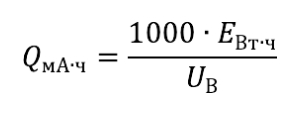

In [302]:
average_voltage = 11.1 # found on the Internet

Wh_to_mAh = lambda Wh: 1000 * Wh / average_voltage

In [303]:
# def foo(val):
#     if pd.isnull(val):
#         return val
#     elif val.split()[1] == 'Вт*ч':
#         return float(val.split()[0])
#     else:
#         return np.nan

# raw_data['battery_capacity'].map(foo).astype(float).hist()

In [304]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val.split()[1] == 'Вт*ч':
        return Wh_to_mAh(float(val.split()[0]))
    else:
        return float(val.split()[0])

raw_data['battery_capacity'] = raw_data['battery_capacity'].map(foo).astype(float)

In [305]:
col_info(20)

col_name = battery_capacity
col_dtype = float64

unique_values_counts:

NaN            175
3693.693694     34
4684.684685     28
5045.045045     26
4343.000000     23
              ... 
6837.837838      1
7207.207207      1
5063.063063      1
4955.000000      1
2500.000000      1
Name: battery_capacity, Length: 96, dtype: int64


In [306]:
col_info(21)

col_name = gaming_laptop
col_dtype = object

unique_values_counts:

нет    500
да     229
Name: gaming_laptop, dtype: int64


In [307]:
raw_data.gaming_laptop = raw_data.gaming_laptop == 'да'

In [308]:
col_info(21)

col_name = gaming_laptop
col_dtype = bool

unique_values_counts:

False    500
True     229
Name: gaming_laptop, dtype: int64


In [309]:
col_info(22)

col_name = kensington_lock
col_dtype = object

unique_values_counts:

есть    477
нет     252
Name: kensington_lock, dtype: int64


In [310]:
raw_data.kensington_lock = raw_data.kensington_lock == 'есть'

In [311]:
col_info(22)

col_name = kensington_lock
col_dtype = bool

unique_values_counts:

True     477
False    252
Name: kensington_lock, dtype: int64


In [312]:
col_info(23)

col_name = producer_code
col_dtype = object

unique_values_counts:

NaN                3
53010TSY           2
NX.GXRER.001       2
NH.Q9HER.00M       1
9SCSR-609RU        1
                  ..
90NB0N01-M05890    1
53011EBR           1
81N300BARU         1
90NB0SR1-M00230    1
22J25EA            1
Name: producer_code, Length: 725, dtype: int64


In [313]:
raw_data.drop('producer_code', axis = 1, inplace = True, errors = 'ignore')

In [314]:
col_info(24)

col_name = cpu_cores_num
col_dtype = int64

unique_values_counts:

4    358
6    156
2    121
8     94
Name: cpu_cores_num, dtype: int64


In [315]:
col_info(25)

col_name = package
col_dtype = object

unique_values_counts:

блок питания, документация                                                                                              459
документация, блок питания                                                                                              209
стилус, блок питания, документация                                                                                        8
стилус, документация, блок питания                                                                                        4
адаптер питания, кабель USB-C для зарядки (2 м)                                                                           4
блок питания, документация, коврик                                                                                        3
документация, адаптер питания                                                                                             3
кабель USB-C для зарядки, адаптер питания USB-C, документация         

In [316]:
list(enumerate(raw_data['package'].unique()))

[(0, 'адаптер питания, документация'),
 (1, 'блок питания, документация'),
 (2, 'стилус, блок питания, документация'),
 (3, 'документация, блок питания'),
 (4, 'документация'),
 (5, 'документация, адаптер питания'),
 (6, 'адаптер питания USB-C, кабель USB, документация'),
 (7, 'кабель USB-C для зарядки, адаптер питания USB-C, документация'),
 (8, 'адаптер питания USB-C, документация, кабель USB'),
 (9, 'переходник USB-RJ45, блок питания, чехол, документация'),
 (10, 'стилус, документация, блок питания'),
 (11, 'адаптер питания, документация, кабель USB'),
 (12, 'адаптер питания, кабель USB, документация'),
 (13, 'блок питания, документация, коврик'),
 (14,
  'переходник USB Type-C — RJ-45 Gigabit, чехол, переходник USB Type C - audio jack, блок питания, документация'),
 (15, 'блок питания, коврик, документация'),
 (16, 'чехол, стилус, блок питания, подставка под запястья, документация'),
 (17, 'чехол, блок питания, подставка под запястья, документация'),
 (18, 'документация, коврик, бл

In [317]:
vals = raw_data['package'].unique()
selected_idxs = [2, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 29, 31, 32]

def foo(val):
    if pd.isnull(val):
        return val
    elif val in vals[selected_idxs]:
        return True
    else:
        return False

raw_data['additional_accessories'] = raw_data['package'].map(foo).astype(bool)
raw_data.drop('package', axis = 1, inplace = True, errors = 'ignore')

In [318]:
col_info(col_name = 'additional_accessories')

col_name = additional_accessories
col_dtype = bool

unique_values_counts:

False    692
True      37
Name: additional_accessories, dtype: int64


In [319]:
col_info(26)

col_name = design
col_dtype = object

unique_values_counts:

классический    683
трансформер      46
Name: design, dtype: int64


In [320]:
raw_data['2_in_1'] = raw_data['design'] == 'трансформер'
raw_data.drop('design', axis = 1, inplace = True, errors = 'ignore')

In [321]:
col_info(col_name = '2_in_1')

col_name = 2_in_1
col_dtype = bool

unique_values_counts:

False    683
True      46
Name: 2_in_1, dtype: int64


In [322]:
col_info(27)

col_name = storage_type
col_dtype = object

unique_values_counts:

только SSD             677
один HDD + один SSD     23
только HDD              12
два SSD                  8
eMMC                     7
один HDD + два SSD       2
Name: storage_type, dtype: int64


In [323]:
# basically, this column can be fully represented by hdd_capacity + ssd_capacity + emmc,
# where emmc_type indicates whether the storage is emcc or not 
# (typically, emmc is like ssd with small capacity for low-price devices)

In [324]:
raw_data['emcc'] = raw_data.storage_type == 'eMMC'
raw_data.drop('storage_type', axis = 1, inplace = True, errors = 'ignore')

In [325]:
col_info(col_name = 'emcc')

col_name = emcc
col_dtype = bool

unique_values_counts:

False    722
True       7
Name: emcc, dtype: int64


In [326]:
col_info(28)

col_name = l2_cache
col_dtype = object

unique_values_counts:

1 Мб      249
2 Мб      164
1.5 Мб    104
4 Мб       81
3 Мб       52
5 Мб       51
512 Кб     17
2.5 Мб      7
NaN         4
Name: l2_cache, dtype: int64


In [327]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val.split()[1] == 'Кб':
        return float(val.split()[0]) / 1024
    else:
        return float(val.split()[0])

raw_data['l2_cache'] = raw_data['l2_cache'].map(foo).astype(float)

In [328]:
col_info(28)

col_name = l2_cache
col_dtype = float64

unique_values_counts:

1.0    249
2.0    164
1.5    104
4.0     81
3.0     52
5.0     51
0.5     17
2.5      7
NaN      4
Name: l2_cache, dtype: int64


In [329]:
col_info(29)

col_name = l3_cache
col_dtype = object

unique_values_counts:

8 Мб     267
12 Мб    135
4 Мб     126
6 Мб     103
нет       36
16 Мб     36
2 Мб      19
NaN        4
3 Мб       2
9 Мб       1
Name: l3_cache, dtype: int64


In [330]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'нет':
        return 0
    else:
        return float(val.split()[0])

raw_data['l3_cache'] = raw_data['l3_cache'].map(foo).astype(float)

In [331]:
col_info(29)

col_name = l3_cache
col_dtype = float64

unique_values_counts:

8.0     267
12.0    135
4.0     126
6.0     103
16.0     36
0.0      36
2.0      19
NaN       4
3.0       2
9.0       1
Name: l3_cache, dtype: int64


In [332]:
col_info(30)

col_name = cpu_family
col_dtype = object

unique_values_counts:

Core i7    225
Core i5    199
Ryzen 5     76
Ryzen 7     56
Core i3     46
Pentium     40
Ryzen 3     37
Athlon      14
Core i9     10
Celeron      8
Ryzen 9      6
A4           5
A9           3
A6           2
M1           2
Name: cpu_family, dtype: int64


In [333]:
col_info(31)

col_name = screen_refresh_rate
col_dtype = object

unique_values_counts:

60 Гц     546
144 Гц     94
120 Гц     48
240 Гц     13
300 Гц     13
NaN        13
нет         2
Name: screen_refresh_rate, dtype: int64


In [334]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'нет':
        return np.nan
    else:
        return float(val.split()[0])

raw_data['screen_refresh_rate'] = raw_data['screen_refresh_rate'].map(foo).astype(float)

In [335]:
col_info(31)

col_name = screen_refresh_rate
col_dtype = float64

unique_values_counts:

60.0     546
144.0     94
120.0     48
NaN       15
300.0     13
240.0     13
Name: screen_refresh_rate, dtype: int64


In [336]:
col_info(32)

col_name = threads_num
col_dtype = float64

unique_values_counts:

8.0     335
4.0     132
12.0    127
16.0     79
6.0      29
2.0      26
NaN       1
Name: threads_num, dtype: int64


In [337]:
col_info(33)

col_name = max_possible_ram
col_dtype = object

unique_values_counts:

32 Гб             228
не добавляется    187
NaN                87
12 Гб              74
16 Гб              73
64 Гб              48
20 Гб              18
8 Гб                8
24 Гб               4
128 Гб              1
48 Гб               1
Name: max_possible_ram, dtype: int64


In [338]:
raw_data['max_possible_ram'] = raw_data[['max_possible_ram', 'ram']].\
        apply(lambda row: row[1] if row[0] == 'не добавляется' or pd.isnull(row[0]) else row[0], axis = 1)

In [339]:
raw_data['max_possible_ram'] = raw_data['max_possible_ram'].map(lambda val: int(val.split()[0]))

In [340]:
col_info(33)

col_name = max_possible_ram
col_dtype = int64

unique_values_counts:

32     230
16     189
8      145
12      74
64      48
20      18
4       18
24       4
128      1
48       1
3        1
Name: max_possible_ram, dtype: int64


In [341]:
col_info(34)

col_name = case_material
col_dtype = object

unique_values_counts:

металл            306
пластик           283
металл/пластик    128
карбон/пластик     11
карбон/металл       1
Name: case_material, dtype: int64


In [342]:
tmp = raw_data['case_material'].map(lambda val: val.split('/'))
tmp

0              [пластик]
1              [пластик]
2              [пластик]
3              [пластик]
4              [пластик]
             ...        
724             [металл]
725             [металл]
726             [металл]
727             [металл]
728    [металл, пластик]
Name: case_material, Length: 729, dtype: object

In [343]:
raw_data['metal'] = tmp.map(lambda val: 'металл' in val)
raw_data['plastic'] = tmp.map(lambda val: 'пластик' in val)
raw_data['carbon'] = tmp.map(lambda val: 'карбон' in val)

In [344]:
raw_data.drop('case_material', axis = 1, inplace = True, errors = 'ignore')

In [345]:
col_info(col_name = 'metal')

col_name = metal
col_dtype = bool

unique_values_counts:

True     435
False    294
Name: metal, dtype: int64


In [346]:
col_info(35)

col_name = model_full_name
col_dtype = object

unique_values_counts:

Lenovo Yoga Slim 7 14IIL05            18
Lenovo IdeaPad 5 14ARE05               6
Lenovo IdeaPad 5 15ARE05               5
Lenovo IdeaPad 3 17ADA05               5
Lenovo Legion 7 15IMH05                5
                                      ..
Acer Aspire 5 A515-44G-R61W            1
ASUS TUF Gaming A17 FX706II-H7059T     1
Acer Swift 3 SF314-58G-57N7            1
MSI GF75 10SCXR-276XRU                 1
Acer Swift 5 SF514-54GT-77G8           1
Name: model_full_name, Length: 647, dtype: int64


In [347]:
raw_data['brand_name'] = raw_data['model_full_name'].map(lambda val: val.split()[0])
raw_data['model_name'] = raw_data['model_full_name'].map(lambda val: " ".join(val.split()[1:]))
raw_data.drop('model_full_name', axis = 1, inplace = True, errors = 'ignore')

In [348]:
col_info(col_name = 'brand_name')

col_name = brand_name
col_dtype = object

unique_values_counts:

Acer      223
ASUS      177
Lenovo    112
HP        109
MSI        58
Huawei     14
Apple      12
Dell       12
Honor      11
Digma       1
Name: brand_name, dtype: int64


In [349]:
col_info(col_name = 'model_name')

col_name = model_name
col_dtype = object

unique_values_counts:

Yoga Slim 7 14IIL05       18
IdeaPad 5 14ARE05          6
IdeaPad 3 17ADA05          5
IdeaPad 5 15ARE05          5
Legion 7 15IMH05           5
                          ..
ThinkBook 13s-IML          1
Nitro 5 AN515-54-5292      1
Laptop F509FB-BQ301T       1
Legion Y740-15IRHg         1
Swift 3 SF314-57G-70XM     1
Name: model_name, Length: 647, dtype: int64


In [350]:
col_info(36)

col_name = integrated_graphics_card_model
col_dtype = object

unique_values_counts:

Intel UHD Graphics 630    208
Intel UHD                 111
Intel UHD Graphics 620     59
Intel Iris Xe              54
Radeon Vega 6              48
Radeon Vega 7              47
Intel Iris Plus            47
Radeon Vega 8              34
Radeon Vega 3              26
Radeon Vega 5              17
Intel UHD 605              17
Radeon Vega 2               8
Intel UHD 600               6
Radeon Vega 10              6
Intel UHD Graphics          6
Intel UHD Graphics 610      5
отключена                   5
Radeon R3                   5
Radeon Graphics             3
Radeon R5                   3
Intel UHD Graphics 605      3
M1 8-core                   2
Radeon R4                   2
Intel UHD 615               2
Intel HD 6000               2
Intel HD 500                1
Intel Iris Plus 645         1
Intel HD Graphics 500       1
Name: integrated_graphics_card_model, dtype: int64


In [351]:
col_info(37)

col_name = dedicated_graphics_card_model
col_dtype = object

unique_values_counts:

нет                            371
GeForce GTX 1650                54
GeForce RTX 2060                48
GeForce GTX 1650 Ti             44
GeForce GTX 1660 Ti             35
GeForce MX350                   25
GeForce RTX 2070 Super          14
GeForce GTX 1660 Ti MaxQ        14
GeForce MX250                   14
GeForce RTX 2070                12
GeForce MX330                   11
GeForce RTX 2080 Super MaxQ      8
GeForce GTX 1650 MaxQ            7
GeForce RTX 2060 MaxQ            7
GeForce MX110                    6
GeForce RTX 2070 MaxQ            6
Radeon 540X                      6
Quadro RTX3000                   5
GeForce RTX 2070 Super MaxQ      5
Radeon RX 5500M                  4
GeForce RTX 2080                 4
GeForce GTX 1650 Ti MaxQ         4
GeForce RTX 2080 MaxQ            3
GeForce RTX 2080 Super           3
GeForce MX450                    3
Radeon Pro 5300M                 2
Radeon

In [352]:
col_info(38)

col_name = cpu_model
col_dtype = object

unique_values_counts:

10750H    68
10300H    51
1035G1    41
1005G1    35
10210U    33
          ..
8250U      1
300U       1
4900HS     1
N3450      1
8300H      1
Name: cpu_model, Length: 62, dtype: int64


In [353]:
col_info(39)

col_name = screen_resolution_name
col_dtype = object

unique_values_counts:

FullHD    639
UHD        38
HD+        18
HD         16
WQXGA      10
QHD         5
WQXGA+      1
WQHD        1
WXGA+       1
Name: screen_resolution_name, dtype: int64


In [354]:
col_info(40)

col_name = hdd_capacity
col_dtype = object

unique_values_counts:

нет        701
1000 ГБ     28
Name: hdd_capacity, dtype: int64


In [355]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'нет':
        return 0
    else:
        return float(val.split()[0])

raw_data['hdd_capacity'] = raw_data['hdd_capacity'].map(foo).astype(float)

In [356]:
col_info(40)

col_name = hdd_capacity
col_dtype = float64

unique_values_counts:

0.0       701
1000.0     28
Name: hdd_capacity, dtype: int64


In [357]:
col_info(41)

col_name = ssd_capacity
col_dtype = object

unique_values_counts:

512 ГБ     336
256 ГБ     225
1024 ГБ    129
128 ГБ      21
2048 ГБ      9
нет          4
64 ГБ        4
32 ГБ        1
Name: ssd_capacity, dtype: int64


In [358]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'нет':
        return 0
    else:
        return float(val.split()[0])

raw_data['ssd_capacity'] = raw_data['ssd_capacity'].map(foo).astype(float)

In [359]:
col_info(41)

col_name = ssd_capacity
col_dtype = float64

unique_values_counts:

512.0     336
256.0     225
1024.0    129
128.0      21
2048.0      9
0.0         4
64.0        4
32.0        1
Name: ssd_capacity, dtype: int64


In [360]:
col_info(42)

col_name = graphics_ram
col_dtype = object

unique_values_counts:

выделяется из оперативной    371
4 Гб                         118
6 Гб                         110
2 Гб                          73
8 Гб                          54
16 Гб                          2
3 Гб                           1
Name: graphics_ram, dtype: int64


In [361]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'выделяется из оперативной':
        return 0
    else:
        return float(val.split()[0])

raw_data['graphics_ram'] = raw_data['graphics_ram'].map(foo).astype(float)

In [362]:
col_info(42)

col_name = graphics_ram
col_dtype = float64

unique_values_counts:

0.0     371
4.0     118
6.0     110
2.0      73
8.0      54
16.0      2
3.0       1
Name: graphics_ram, dtype: int64


In [363]:
col_info(43)

col_name = intel_optane_drive_capacity
col_dtype = object

unique_values_counts:

нет      723
NaN        5
32 ГБ      1
Name: intel_optane_drive_capacity, dtype: int64


In [364]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'нет':
        return 0
    else:
        return float(val.split()[0])

raw_data['intel_optane_drive_capacity'] = raw_data['intel_optane_drive_capacity'].map(foo).astype(float)

In [365]:
col_info(43)

col_name = intel_optane_drive_capacity
col_dtype = float64

unique_values_counts:

0.0     723
NaN       5
32.0      1
Name: intel_optane_drive_capacity, dtype: int64


In [366]:
col_info(44)

col_name = os
col_dtype = object

unique_values_counts:

Windows 10 Home            427
DOS                        115
UNIX-подобная               90
Windows 10 Professional     74
macOS                       12
Windows 10 S                11
Name: os, dtype: int64


In [367]:
col_info(45)

col_name = optical_disc_drive
col_dtype = object

unique_values_counts:

нет           724
DVD-SMulti      5
Name: optical_disc_drive, dtype: int64


In [368]:
raw_data['optical_disc_drive'] = raw_data['optical_disc_drive'].map(lambda val: False if val == 'нет' else True)

In [369]:
col_info(45)

col_name = optical_disc_drive
col_dtype = bool

unique_values_counts:

False    724
True       5
Name: optical_disc_drive, dtype: int64


In [370]:
col_info(46)

col_name = ppi
col_dtype = object

unique_values_counts:

141 PPI      328
157 PPI      110
127 PPI       91
157.4 PPI     54
165.6 PPI     19
282 PPI       18
106 PPI       14
166 PPI       12
101 PPI        9
137 PPI        7
255 PPI        6
127.3 PPI      6
227 PPI        6
201 PPI        5
141            5
141.2 PPI      4
200 PPI        4
169 PPI        4
226 PPI        4
135 PPI        3
156.2 PPI      2
254.7 PPI      2
127.7 PPI      2
282.4 PPI      2
314 PPI        2
100 PPI        1
331 PPI        1
277 PPI        1
149 PPI        1
314.7 PPI      1
190 PPI        1
106.1 PPI      1
210 PPI        1
260 PPI        1
157            1
Name: ppi, dtype: int64


In [371]:
raw_data['ppi'] = raw_data['ppi'].map(lambda val: float(val.split()[0]))

In [372]:
col_info(46)

col_name = ppi
col_dtype = float64

unique_values_counts:

141.0    333
157.0    111
127.0     91
157.4     54
165.6     19
282.0     18
106.0     14
166.0     12
101.0      9
137.0      7
127.3      6
227.0      6
255.0      6
201.0      5
141.2      4
226.0      4
169.0      4
200.0      4
135.0      3
282.4      2
156.2      2
314.0      2
254.7      2
127.7      2
100.0      1
190.0      1
106.1      1
260.0      1
210.0      1
277.0      1
314.7      1
331.0      1
149.0      1
Name: ppi, dtype: int64


In [373]:
col_info(47)

col_name = usb_power_delivery
col_dtype = object

unique_values_counts:

нет     362
есть    197
NaN     170
Name: usb_power_delivery, dtype: int64


In [374]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'нет':
        return False
    else:
        return True

raw_data['usb_power_delivery'] = raw_data['usb_power_delivery'].map(foo).astype(float)

In [375]:
col_info(47)

col_name = usb_power_delivery
col_dtype = float64

unique_values_counts:

0.0    362
1.0    197
NaN    170
Name: usb_power_delivery, dtype: int64


In [376]:
col_info(48)

col_name = additional_data_transfer_methods
col_dtype = object

unique_values_counts:

Bluetooth 5.0               414
Bluetooth 5.1                80
Bluetooth 4.2                70
Bluetooth 4.1                61
Miracast , Bluetooth 5.0     33
Bluetooth 5.0 , Miracast     19
Bluetooth                    18
Bluetooth 4.2 , Miracast     18
Bluetooth 4.0                 8
NFC , Bluetooth 5.0           4
Miracast , Bluetooth 4.2      3
нет                           1
Name: additional_data_transfer_methods, dtype: int64


In [377]:
tmp = raw_data.additional_data_transfer_methods.map(lambda val: val.replace(' ', '').split(','))
print(np.unique(list(reduce(lambda l1, l2: l1 + l2, tmp))))

['Bluetooth' 'Bluetooth4.0' 'Bluetooth4.1' 'Bluetooth4.2' 'Bluetooth5.0'
 'Bluetooth5.1' 'Miracast' 'NFC' 'нет']


In [378]:
raw_data['bluetooth'] = tmp.map(lambda vals: 'bluetooth' in vals).astype(int)

raw_data['bluetooth_4_0'] = tmp.map(lambda vals: 'Bluetooth4.0' in vals).astype(bool)
raw_data['bluetooth_4_1'] = tmp.map(lambda vals: 'Bluetooth4.1' in vals).astype(bool)
raw_data['bluetooth_4_2'] = tmp.map(lambda vals: 'Bluetooth4.2' in vals).astype(bool)
raw_data['bluetooth_5_0'] = tmp.map(lambda vals: 'Bluetooth5.0' in vals).astype(bool)
raw_data['bluetooth_5_1'] = tmp.map(lambda vals: 'Bluetooth5.1' in vals).astype(bool)

raw_data['bluetooth'] += raw_data['bluetooth_4_0']
raw_data['bluetooth'] += raw_data['bluetooth_4_1']
raw_data['bluetooth'] += raw_data['bluetooth_4_2']
raw_data['bluetooth'] += raw_data['bluetooth_5_0']
raw_data['bluetooth'] += raw_data['bluetooth_5_1']

raw_data['bluetooth'] = raw_data['bluetooth'].astype(bool)

raw_data['miracast'] = tmp.map(lambda vals: 'Miracast' in vals).astype(bool)

raw_data['nfc'] = tmp.map(lambda vals: 'NFC' in vals).astype(bool)

raw_data.drop('additional_data_transfer_methods', axis = 1, inplace = True, errors = 'ignore')

In [379]:
col_info(col_name = 'bluetooth')

col_name = bluetooth
col_dtype = bool

unique_values_counts:

True     710
False     19
Name: bluetooth, dtype: int64


In [380]:
col_info(col_name = 'bluetooth_5_1')

col_name = bluetooth_5_1
col_dtype = bool

unique_values_counts:

False    649
True      80
Name: bluetooth_5_1, dtype: int64


In [381]:
col_info(col_name = 'nfc')

col_name = nfc
col_dtype = bool

unique_values_counts:

False    725
True       4
Name: nfc, dtype: int64


In [382]:
col_info(49)

col_name = supported_memory_card
col_dtype = object

unique_values_counts:

нет                                   329
micro SDXC , micro SDHC , micro SD    116
NaN                                    56
SD , SDHC , SDXC                       52
micro SDHC , micro SDXC , micro SD     30
SDXC , SDHC , SD                       27
SD , SDXC , SDHC                       17
micro SD                               16
SDHC , SDXC , SD                       12
SD , SDHC , SDXC , MMC                 11
MMC , SDXC , SDHC , SD                 10
SDHC , MMC , SDXC , SD                  9
SDXC , SD , SDHC                        7
SD                                      7
SDXC , MMC , SDHC , SD                  6
MMC , SD , SDHC , SDXC                  5
SD , SDHC , MMC , SDXC                  4
SDHC , SD , SDXC                        3
SDHC , SDXC , MMC , SD                  2
SD , MMC , SDXC , SDHC                  2
SDHC , MMC , SD , SDXC                  2
MicroMedia , SD                         1


In [383]:
tmp = raw_data.supported_memory_card.map(lambda val: [] if pd.isnull(val) else val.replace(' ', '').split(','))
print(np.unique(list(reduce(lambda l1, l2: l1 + l2, tmp))))

['MMC' 'MS' 'MicroMedia' 'SD' 'SDHC' 'SDXC' 'microSD' 'microSDHC'
 'microSDXC' 'нет']


In [384]:
raw_data['mmc'] = tmp.map(lambda vals: 'MMC' in vals).astype(bool)
raw_data['ms'] = tmp.map(lambda vals: 'MS' in vals).astype(bool)
raw_data['micro_media'] = tmp.map(lambda vals: 'MicroMedia' in vals).astype(bool)
raw_data['sd'] = tmp.map(lambda vals: 'SD' in vals).astype(bool)
raw_data['sdhc'] = tmp.map(lambda vals: 'SDHC' in vals).astype(bool)
raw_data['sdxc'] = tmp.map(lambda vals: 'SDXC' in vals).astype(bool)
raw_data['micro_sd'] = tmp.map(lambda vals: 'microSD' in vals).astype(bool)
raw_data['micro_sdhc'] = tmp.map(lambda vals: 'microSDHC' in vals).astype(bool)
raw_data['micro_sdxc'] = tmp.map(lambda vals: 'microSDXC' in vals).astype(bool)

raw_data.drop('supported_memory_card', axis = 1, inplace = True, errors = 'ignore')

In [385]:
col_info(col_name = 'micro_sdhc')

col_name = micro_sdhc
col_dtype = bool

unique_values_counts:

False    583
True     146
Name: micro_sdhc, dtype: int64


In [386]:
col_info(50)

col_name = keyboard_backlight
col_dtype = object

unique_values_counts:

есть           562
нет            151
опционально      8
NaN              8
Name: keyboard_backlight, dtype: int64


In [387]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'есть':
        return 1
    elif val == 'опционально':
        return 0.5
    else:
        return 0

raw_data['keyboard_backlight'] = raw_data['keyboard_backlight'].map(foo).astype(float)

In [388]:
col_info(50)

col_name = keyboard_backlight
col_dtype = float64

unique_values_counts:

1.0    562
0.0    151
NaN      8
0.5      8
Name: keyboard_backlight, dtype: int64


In [389]:
col_info(51)

col_name = screen_coating
col_dtype = object

unique_values_counts:

матовое      630
глянцевое     86
NaN           13
Name: screen_coating, dtype: int64


In [390]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'глянцевое':
        return True
    else:
        return False

raw_data['glossy_display'] = raw_data['screen_coating'].map(foo).astype(float)

raw_data.drop('screen_coating', axis = 1, inplace = True, errors = 'ignore')

In [391]:
col_info(col_name = 'glossy_display')

col_name = glossy_display
col_dtype = float64

unique_values_counts:

0.0    630
1.0     86
NaN     13
Name: glossy_display, dtype: int64


In [392]:
col_info(52)

col_name = usb_2_0_ports
col_dtype = object

unique_values_counts:

нет    383
1      219
2      127
Name: usb_2_0_ports, dtype: int64


In [393]:
raw_data['usb_2_0_ports'] = raw_data['usb_2_0_ports'].map(lambda val: 0 if val == 'нет' else val).astype(float)

In [394]:
col_info(52)

col_name = usb_2_0_ports
col_dtype = float64

unique_values_counts:

0.0    383
1.0    219
2.0    127
Name: usb_2_0_ports, dtype: int64


In [395]:
col_info(53)

col_name = usb_3_x_ports
col_dtype = object

unique_values_counts:

2      319
1      206
3      158
нет     40
4        6
Name: usb_3_x_ports, dtype: int64


In [396]:
raw_data['usb_3_x_ports'] = raw_data['usb_3_x_ports'].map(lambda val: 0 if val == 'нет' else val).astype(float)

In [397]:
col_info(53)

col_name = usb_3_x_ports
col_dtype = float64

unique_values_counts:

2.0    319
1.0    206
3.0    158
0.0     40
4.0      6
Name: usb_3_x_ports, dtype: int64


In [398]:
col_info(54)

col_name = usb_type_c_ports
col_dtype = object

unique_values_counts:

1      511
2      126
нет     83
4        7
3        2
Name: usb_type_c_ports, dtype: int64


In [399]:
raw_data['usb_type_c_ports'] = raw_data['usb_type_c_ports'].map(lambda val: 0 if val == 'нет' else val).astype(float)

In [400]:
col_info(54)

col_name = usb_type_c_ports
col_dtype = float64

unique_values_counts:

1.0    511
2.0    126
0.0     83
4.0      7
3.0      2
Name: usb_type_c_ports, dtype: int64


In [401]:
col_info(55)

col_name = estimated_battery_life
col_dtype = object

unique_values_counts:

NaN       176
8 ч        96
7 ч        63
10 ч       55
6 ч        50
12 ч       42
11 ч       35
5 ч        35
4 ч        34
9 ч        31
14 ч       26
3 ч        22
11.5 ч     11
15 ч        8
16 ч        7
10.5 ч      5
24 ч        5
17 ч        4
22 ч        4
18 ч        3
13.5 ч      3
13 ч        3
4.5 ч       2
20 ч        2
17.5 ч      2
19.3 ч      2
3.5 ч       1
2.5 ч       1
15.9 ч      1
Name: estimated_battery_life, dtype: int64


In [402]:
raw_data['estimated_battery_life'] = raw_data.estimated_battery_life.\
                                            map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [403]:
col_info(55)

col_name = estimated_battery_life
col_dtype = float64

unique_values_counts:

NaN     176
8.0      96
7.0      63
10.0     55
6.0      50
12.0     42
5.0      35
11.0     35
4.0      34
9.0      31
14.0     26
3.0      22
11.5     11
15.0      8
16.0      7
10.5      5
24.0      5
17.0      4
22.0      4
13.0      3
13.5      3
18.0      3
19.3      2
17.5      2
20.0      2
4.5       2
15.9      1
3.5       1
2.5       1
Name: estimated_battery_life, dtype: int64


In [404]:
col_info(56)

col_name = gpu_manufacturer
col_dtype = object

unique_values_counts:

nVidia    329
Intel     251
AMD       147
Apple       2
Name: gpu_manufacturer, dtype: int64


In [405]:
col_info(57)

col_name = cpu_manufacturer
col_dtype = object

unique_values_counts:

Intel    528
AMD      199
Apple      2
Name: cpu_manufacturer, dtype: int64


In [406]:
col_info(58)

col_name = ram
col_dtype = object

unique_values_counts:

8 ГБ     317
16 ГБ    292
4 ГБ      78
32 ГБ     36
12 ГБ      3
3 ГБ       1
24 ГБ      1
64 ГБ      1
Name: ram, dtype: int64


In [407]:
raw_data['ram'] = raw_data.ram.map(lambda val: val.split()[0]).astype(int)

In [408]:
col_info(58)

col_name = ram
col_dtype = int32

unique_values_counts:

8     317
16    292
4      78
32     36
12      3
64      1
24      1
3       1
Name: ram, dtype: int64


In [409]:
col_info(59)

col_name = screen_resolution
col_dtype = object

unique_values_counts:

1920x1080    635
3840x2160     32
1600x900      18
1366x768      15
2560x1600      6
2256x1504      5
2160x1440      4
3072x1920      4
1920x1200      4
1440x900       2
3000x2000      2
2560x1440      1
1280x800       1
Name: screen_resolution, dtype: int64


In [410]:
tmp = raw_data.screen_resolution.map(lambda val: val.split('x'))
tmp

0       [1280, 800]
1       [1366, 768]
2       [1366, 768]
3       [1366, 768]
4       [1366, 768]
           ...     
724    [3840, 2160]
725    [3840, 2160]
726    [3840, 2160]
727    [3840, 2160]
728    [3840, 2160]
Name: screen_resolution, Length: 729, dtype: object

In [411]:
raw_data['screen_width_pixels'] = tmp.map(lambda vals: vals[0]).astype(int)
raw_data['screen_height_pixels'] = tmp.map(lambda vals: vals[1]).astype(int)

raw_data.drop('screen_resolution', axis = 1, inplace = True, errors = 'ignore')

In [412]:
col_info(col_name = 'screen_width_pixels')

col_name = screen_width_pixels
col_dtype = int32

unique_values_counts:

1920    639
3840     32
1600     18
1366     15
2560      7
2256      5
2160      4
3072      4
3000      2
1440      2
1280      1
Name: screen_width_pixels, dtype: int64


In [413]:
col_info(60)

col_name = M_2_connector
col_dtype = object

unique_values_counts:

есть    700
нет      22
NaN       7
Name: M_2_connector, dtype: int64


In [414]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'есть':
        return True
    else:
        return False

raw_data['M_2_connector'] = raw_data['M_2_connector'].map(foo).astype(float)

In [415]:
col_info(60)

col_name = M_2_connector
col_dtype = float64

unique_values_counts:

1.0    700
0.0     22
NaN      7
Name: M_2_connector, dtype: int64


In [416]:
col_info(61)

col_name = sound_system
col_dtype = object

unique_values_counts:

стереодинамики                                                 112
Acer TrueHarmony                                               103
Dolby Atmos                                                     57
Dolby Audio                                                     54
DTS:X Ultra                                                     46
два динамика                                                    41
NaN                                                             32
Smart AMP                                                       30
Nahimic 3                                                       27
ASUS SonicMaster , ICEpower                                     26
Harman kardon                                                   23
Bang & Olufsen с 2 динамиками, HP Audio Boost                   20
HP Audio Boost , Bang & Olufsen с 2 динамиками                  15
ASUS SonicMaster                                              

In [417]:
col_info(62)

col_name = touch_screen
col_dtype = object

unique_values_counts:

нет     664
есть     65
Name: touch_screen, dtype: int64


In [418]:
raw_data['touch_screen'] = raw_data['touch_screen'] == 'есть'

In [419]:
col_info(62)

col_name = touch_screen
col_dtype = bool

unique_values_counts:

False    664
True      65
Name: touch_screen, dtype: int64


In [420]:
col_info(63)

col_name = fingerprint_scanner
col_dtype = object

unique_values_counts:

нет            492
есть           225
опционально     12
Name: fingerprint_scanner, dtype: int64


In [421]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'есть':
        return 1
    elif val == 'опционально':
        return 0.5
    else:
        return 0

raw_data['fingerprint_scanner'] = raw_data['fingerprint_scanner'].map(foo).astype(float)

In [422]:
col_info(63)

col_name = fingerprint_scanner
col_dtype = float64

unique_values_counts:

0.0    492
1.0    225
0.5     12
Name: fingerprint_scanner, dtype: int64


In [423]:
col_info(64)

col_name = hdd_rpm
col_dtype = object

unique_values_counts:

нет            687
5400 об/мин     20
NaN             14
7200 об/мин      8
Name: hdd_rpm, dtype: int64


In [424]:
raw_data.hdd_capacity.value_counts(dropna = False)

0.0       701
1000.0     28
Name: hdd_capacity, dtype: int64

In [425]:
raw_data['hdd_increased_speed'] = raw_data['hdd_rpm'] == '7200 об/мин'
raw_data.drop('hdd_rpm', axis = 1, inplace = True, errors = 'ignore')

In [426]:
col_info(col_name = 'hdd_increased_speed')

col_name = hdd_increased_speed
col_dtype = bool

unique_values_counts:

False    721
True       8
Name: hdd_increased_speed, dtype: int64


In [427]:
col_info(65)

col_name = wi_fi_standard
col_dtype = object

unique_values_counts:

6 (802.11ax)                                 384
5 (802.11ac)                                 328
5 (802.11ac) , 4 (802.11n)                    12
4 (802.11n)                                    2
5 (802.11ac) , 6 (802.11ax)                    1
5 (802.11ac) , 6 (802.11ax) , 4 (802.11n)      1
6 (802.11ax) , 5 (802.11ac)                    1
Name: wi_fi_standard, dtype: int64


In [428]:
tmp = raw_data['wi_fi_standard'].map(lambda val: val.split(','))
tmp

0       [4 (802.11n)]
1      [5 (802.11ac)]
2      [5 (802.11ac)]
3      [5 (802.11ac)]
4      [5 (802.11ac)]
            ...      
724    [6 (802.11ax)]
725    [5 (802.11ac)]
726    [6 (802.11ax)]
727    [5 (802.11ac)]
728    [6 (802.11ax)]
Name: wi_fi_standard, Length: 729, dtype: object

In [429]:
raw_data['best_wi_fi_standard'] = tmp.map(lambda vals: max([int(val.split()[0]) for val in vals]))
raw_data.drop('wi_fi_standard', axis = 1, inplace = True, errors = 'ignore')

In [430]:
col_info(col_name = 'best_wi_fi_standard')

col_name = best_wi_fi_standard
col_dtype = int64

unique_values_counts:

6    387
5    340
4      2
Name: best_wi_fi_standard, dtype: int64


In [431]:
col_info(66)

col_name = manufacturer_country
col_dtype = object

unique_values_counts:

Китай    551
NaN      178
Name: manufacturer_country, dtype: int64


In [432]:
raw_data.drop('manufacturer_country', axis = 1, inplace = True, errors = 'ignore')

In [433]:
col_info(67)

col_name = cpu_lithography
col_dtype = object

unique_values_counts:

14 нм    380
10 нм    180
7 нм     124
12 нм     30
28 нм     10
NaN        3
5 нм       2
Name: cpu_lithography, dtype: int64


In [434]:
raw_data['cpu_lithography'] = raw_data.cpu_lithography.\
                                    map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [435]:
col_info(67)

col_name = cpu_lithography
col_dtype = float64

unique_values_counts:

14.0    380
10.0    180
7.0     124
12.0     30
28.0     10
NaN       3
5.0       2
Name: cpu_lithography, dtype: int64


In [436]:
col_info(68)

col_name = battery_type
col_dtype = object

unique_values_counts:

Li-Ion    421
Li-Pol    307
NaN         1
Name: battery_type, dtype: int64


In [437]:
raw_data['li_ion_battery_type'] = raw_data['battery_type'] == 'Li-Ion'
raw_data.drop('battery_type', axis = 1, inplace = True, errors = 'ignore')

In [438]:
col_info(69)

col_name = graphics_ram_type
col_dtype = object

unique_values_counts:

SMA      367
GDDR6    261
GDDR5     97
NaN        4
Name: graphics_ram_type, dtype: int64


In [439]:
col_info(70)

col_name = ram_type
col_dtype = object

unique_values_counts:

DDR4       633
LPDDR4x     58
LPDDR3      25
LPDDR4      12
DDR3L        1
Name: ram_type, dtype: int64


In [440]:
col_info(71)

col_name = device_type
col_dtype = object

unique_values_counts:

ноутбук      619
ультрабук    109
нетбук         1
Name: device_type, dtype: int64


In [441]:
raw_data['ultrabook'] = raw_data['device_type'] == 'ультрабук'
raw_data.drop('device_type', axis = 1, inplace = True, errors = 'ignore')

In [442]:
col_info(col_name = 'ultrabook')

col_name = ultrabook
col_dtype = bool

unique_values_counts:

False    620
True     109
Name: ultrabook, dtype: int64


In [443]:
col_info(72)

col_name = display_type
col_dtype = object

unique_values_counts:

IPS              635
TN+film           77
SVA (TN+film)      9
WVA                4
OLED               4
Name: display_type, dtype: int64


In [444]:
col_info(73)

col_name = height
col_dtype = object

unique_values_counts:

19.9 мм    88
17.9 мм    51
16.9 мм    38
14.9 мм    35
24.9 мм    33
           ..
26.3 мм     1
14.6 мм     1
22.6 мм     1
14.1 мм     1
39.8 мм     1
Name: height, Length: 86, dtype: int64


In [445]:
raw_data['height'] = raw_data['height'].map(lambda val: val.split()[0]).astype(float)

In [446]:
col_info(73)

col_name = height
col_dtype = float64

unique_values_counts:

19.90    88
17.90    51
16.90    38
14.90    35
24.90    33
         ..
26.30     1
29.00     1
15.40     1
14.60     1
24.95     1
Name: height, Length: 86, dtype: int64


In [447]:
col_info(74)

col_name = color
col_dtype = object

unique_values_counts:

черный         336
серый          143
серебристый    134
синий           41
белый           37
красный         13
розовый         11
зеленый         10
золотистый       4
Name: color, dtype: int64


In [448]:
col_info(75)

col_name = color_gamut
col_dtype = object

unique_values_counts:

NaN                                 222
45% NTSC                            181
100% sRGB                           111
72% NTSC                             40
100% AdobeRGB                        29
50% AdobeRGB, 67% sRGB, 45% NTSC     14
54% sRGB                             13
62% sRGB, 45% NTSC                   10
60% NTSC                              7
100% sRGB, 72% NTSC                   7
39% AdobeRGB, 62% sRGB                6
77% AdobeRGB                          5
94% sRGB                              5
100% DCI-P3                           5
92% sRGB, 60% AdobeRGB                4
85% sRGB, 63% AdobeRGB                4
36% AdobeRGB, 57% sRGB                4
62% sRGB, 39% AdobeRGB                4
56% sRGB                              3
67% sRGB, 50% AdobeRGB                3
91% sRGB, 59% AdobeRGB                3
47% AdobeRGB, 62% sRGB, 45% NTSC      3
48% AdobeRGB, 64% sRGB, 45% NTSC      3
58% sRGB, 37% 

In [449]:
col_info(76)

col_name = numeric_keypad
col_dtype = object

unique_values_counts:

есть         403
нет          317
сенсорный      9
Name: numeric_keypad, dtype: int64


In [450]:
raw_data['touch_numeric_keypad'] = raw_data['numeric_keypad'] == 'сенсорный'
raw_data['numeric_keypad'] = raw_data['numeric_keypad'] != 'нет'

In [451]:
col_info(76)

col_name = numeric_keypad
col_dtype = bool

unique_values_counts:

True     412
False    317
Name: numeric_keypad, dtype: int64


In [452]:
col_info(col_name = 'touch_numeric_keypad')

col_name = touch_numeric_keypad
col_dtype = bool

unique_values_counts:

False    720
True       9
Name: touch_numeric_keypad, dtype: int64


In [453]:
col_info(77)

col_name = cpu_frequency
col_dtype = object

unique_values_counts:

2.6 ГГц    124
2.3 ГГц     85
2.4 ГГц     67
2.5 ГГц     53
1 ГГц       41
2.1 ГГц     39
1.1 ГГц     38
1.8 ГГц     37
1.6 ГГц     36
1.2 ГГц     35
2.9 ГГц     31
1.3 ГГц     29
3 ГГц       27
2 ГГц       25
2.8 ГГц     24
2.7 ГГц     17
3.3 ГГц      5
1.5 ГГц      5
3.1 ГГц      3
1.7 ГГц      3
2.2 ГГц      2
NaN          2
1.4 ГГц      1
Name: cpu_frequency, dtype: int64


In [454]:
raw_data['cpu_frequency'] = raw_data.cpu_frequency.\
                                    map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [455]:
col_info(77)

col_name = cpu_frequency
col_dtype = float64

unique_values_counts:

2.6    124
2.3     85
2.4     67
2.5     53
1.0     41
2.1     39
1.1     38
1.8     37
1.6     36
1.2     35
2.9     31
1.3     29
3.0     27
2.0     25
2.8     24
2.7     17
1.5      5
3.3      5
3.1      3
1.7      3
NaN      2
2.2      2
1.4      1
Name: cpu_frequency, dtype: int64


In [456]:
col_info(78)

col_name = ram_frequency
col_dtype = object

unique_values_counts:

2666 МГц    197
3200 МГц    177
2933 МГц    109
2400 МГц     92
2133 МГц     74
NaN          49
3733 МГц     14
1866 МГц     10
4266 МГц      4
1600 МГц      3
Name: ram_frequency, dtype: int64


In [457]:
raw_data['ram_frequency'] = raw_data.ram_frequency.\
                                    map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [458]:
col_info(78)

col_name = ram_frequency
col_dtype = float64

unique_values_counts:

2666.0    197
3200.0    177
2933.0    109
2400.0     92
2133.0     74
NaN        49
3733.0     14
1866.0     10
4266.0      4
1600.0      3
Name: ram_frequency, dtype: int64


In [459]:
col_info(79)

col_name = width
col_dtype = object

unique_values_counts:

363.4 мм    87
360 мм      46
358.5 мм    37
359 мм      30
324 мм      26
            ..
310.4 мм     1
399.7 мм     1
304.9 мм     1
284.4 мм     1
NaN          1
Name: width, Length: 102, dtype: int64


In [460]:
raw_data['width'] = raw_data.width.\
                            map(lambda val: np.nan if pd.isnull(val) else val.split()[0]).astype(float)

In [461]:
col_info(79)

col_name = width
col_dtype = float64

unique_values_counts:

363.4    87
360.0    46
358.5    37
359.0    30
324.0    26
         ..
284.4     1
327.1     1
318.7     1
389.0     1
268.0     1
Name: width, Length: 102, dtype: int64


In [462]:
col_info(80)

col_name = release_year
col_dtype = float64

unique_values_counts:

2020.0    652
2019.0     65
NaN         8
2017.0      2
2018.0      2
Name: release_year, dtype: int64


In [463]:
col_info(81)

col_name = memory_slots_num
col_dtype = object

unique_values_counts:

2                315
интегрирована    193
1                167
NaN               49
4                  5
Name: memory_slots_num, dtype: int64


In [464]:
def foo(val):
    if pd.isnull(val):
        return val
    elif val == 'интегрирована':
        return 0
    else:
        return val

raw_data['memory_slots_num'] = raw_data['memory_slots_num'].map(foo).astype(float)

In [465]:
col_info(81)

col_name = memory_slots_num
col_dtype = float64

unique_values_counts:

2.0    315
0.0    193
1.0    167
NaN     49
4.0      5
Name: memory_slots_num, dtype: int64


In [466]:
col_info(82)

col_name = additional_info
col_dtype = object

unique_values_counts:

NaN                                                                                                                             576
NumberPad                                                                                                                        37
шторка веб-камеры                                                                                                                13
акселерометр                                                                                                                     11
датчик Холла                                                                                                                     11
датчик Холла , датчик внешней освещенности                                                                                        8
совмещенный разъем Type-C / DisplayPort, акселерометр                                                                             7
поддер

In [467]:
col_info(83)

col_name = ethernet_adapter_speed
col_dtype = object

unique_values_counts:

1000 Мбит    350
нет          346
NaN           31
100 Мбит       1
2500 Мбит      1
Name: ethernet_adapter_speed, dtype: int64


In [468]:
raw_data.drop('ethernet_adapter_speed', axis = 1, inplace = True, errors = 'ignore')

In [469]:
col_info(84)

col_name = adaptive_sync_technology
col_dtype = object

unique_values_counts:

нет              559
NaN               68
NVIDIA G-SYNC     67
Adaptive-Sync     29
AMD FreeSync       6
Name: adaptive_sync_technology, dtype: int64


In [470]:
data = raw_data.copy()

In [471]:
data.to_csv('data.csv', index = False)

## Categorical data encoding

In [235]:
data.dtypes[data.dtypes == object]

cpu_architecture                  object
package                           object
cpu_family                        object
integrated_graphics_card_model    object
dedicated_graphics_card_model     object
cpu_model                         object
screen_resolution_name            object
os                                object
gpu_manufacturer                  object
cpu_manufacturer                  object
sound_system                      object
graphics_ram_type                 object
ram_type                          object
display_type                      object
color                             object
color_gamut                       object
additional_info                   object
adaptive_sync_technology          object
brand_name                        object
model_name                        object
dtype: object

In [236]:
print_whole_df(data.cpu_model.value_counts(dropna = False))

10750H          68
10300H          51
1035G1          41
1005G1          35
10210U          33
9750H           32
10510U          30
1065G7          29
4500U           29
9300H           27
10875H          24
1165G7          24
4800H           23
1135G7          22
3500U           18
4300U           17
Silver N5030    15
1035G4          15
4600H           14
4700U           13
3200U           13
Gold 5405U      10
0               10
Gold 6405U       9
Silver 3050U     9
4800HS           8
3250U            7
3550H            7
1185G7           7
Pro 4650U        7
10110U           6
N4020            5
1115G4           5
4900H            5
10980HK          5
Silver N5000     5
3750H            4
Gold 3150U       4
9120e            3
4800U            3
9425             3
Pro 4750U        3
10710U           3
9880H            2
9225             2
3700U            2
8265U            2
M1               2
9125             2
10870H           2
8565U            2
8500Y            2
8250U       

## Train-test splitting function

In [260]:
data[['brand_name', 'model_name', 'price', 'cpu_manufacturer', 'cpu_family', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color']]\
        [data.duplicated(['brand_name', 'price'], keep = False)]

,brand_name,model_name,price,cpu_manufacturer,cpu_family,cpu_model,hdd_capacity,ssd_capacity,os,ram,color
1,ASUS,Laptop E210MA-GJ001T,24999.0,Intel,Celeron,N4020,0.0,64.0,Windows 10 Home,4,синий
2,ASUS,Laptop E210MA-GJ002T,24999.0,Intel,Celeron,N4020,0.0,64.0,Windows 10 Home,4,розовый
3,ASUS,Laptop E210MA-GJ003T,24999.0,Intel,Celeron,N4020,0.0,64.0,Windows 10 Home,4,белый
7,Acer,Aspire 3 A315-22-43HR,29999.0,AMD,A4,9120e,0.0,256.0,UNIX-подобная,8,черный
8,Acer,Aspire 3 A315-34-C1QD,29999.0,Intel,Celeron,N4000,0.0,128.0,UNIX-подобная,4,черный
...,...,...,...,...,...,...,...,...,...,...,...
701,Apple,MacBook Pro Retina TB (MVVL2RU/A),220499.0,Intel,Core i7,0,0.0,512.0,macOS,16,серебристый
710,ASUS,ROG Strix SCAR G732LXS-HG092T,233999.0,Intel,Core i9,10980HK,0.0,2048.0,Windows 10 Home,32,черный
711,ASUS,ROG Zephyrus S17 GX701LXS-HG057T,233999.0,Intel,Core i7,10875H,0.0,1024.0,Windows 10 Home,32,черный
715,Apple,MacBook Pro Retina TB (MVVK2RU/A),256499.0,Intel,Core i9,0,0.0,1024.0,macOS,16,серый


In [247]:
data.columns.values

array(['average_rating', 'price', 'reviews_num', 'max_cpu_frequency',
       'cpu_architecture', 'web_camera', 'weight', 'ethernet_adapter',
       'pixel_response_time', 'microphone', 'warranty_duration', 'depth',
       'screen_diagonal', 'battery_capacity', 'gaming_laptop',
       'kensington_lock', 'cpu_cores_num', 'package', 'l2_cache',
       'l3_cache', 'cpu_family', 'screen_refresh_rate', 'threads_num',
       'max_possible_ram', 'integrated_graphics_card_model',
       'dedicated_graphics_card_model', 'cpu_model',
       'screen_resolution_name', 'hdd_capacity', 'ssd_capacity',
       'graphics_ram', 'intel_optane_drive_capacity', 'os',
       'optical_disc_drive', 'ppi', 'usb_power_delivery',
       'keyboard_backlight', 'usb_2_0_ports', 'usb_3_x_ports',
       'usb_type_c_ports', 'estimated_battery_life', 'gpu_manufacturer',
       'cpu_manufacturer', 'ram', 'M_2_connector', 'sound_system',
       'touch_screen', 'fingerprint_scanner', 'cpu_lithography',
       'graphics_ram

In [263]:
data[['brand_name', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color']].head(7)

,brand_name,cpu_model,hdd_capacity,ssd_capacity,os,ram,color
0,Digma,N3450,0.0,32.0,Windows 10 Home,3,черный
1,ASUS,N4020,0.0,64.0,Windows 10 Home,4,синий
2,ASUS,N4020,0.0,64.0,Windows 10 Home,4,розовый
3,ASUS,N4020,0.0,64.0,Windows 10 Home,4,белый
4,ASUS,9125,0.0,256.0,UNIX-подобная,4,черный
5,Acer,9120e,0.0,128.0,UNIX-подобная,4,черный
6,ASUS,N4020,0.0,128.0,DOS,4,черный


In [307]:
data[['brand_name', 'price', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color', 'display_type']][data.duplicated(np.delete(data.columns, np.where(data.columns == 'color')), keep = False)]

,brand_name,price,cpu_model,hdd_capacity,ssd_capacity,os,ram,color,display_type
30,Lenovo,34999.0,Silver 3050U,0.0,256.0,DOS,4,серый,TN+film
31,Lenovo,34999.0,Silver 3050U,0.0,256.0,DOS,4,синий,TN+film
126,Lenovo,45999.0,4300U,0.0,512.0,DOS,8,серый,IPS
127,Lenovo,45999.0,4300U,0.0,512.0,DOS,8,синий,IPS
420,Lenovo,84999.0,1035G4,0.0,256.0,Windows 10 Home,8,красный,IPS
421,Lenovo,84999.0,1035G4,0.0,256.0,Windows 10 Home,8,серый,IPS
462,Lenovo,89999.0,1035G4,0.0,512.0,Windows 10 Home,16,серый,IPS
463,Lenovo,89999.0,1035G4,0.0,512.0,Windows 10 Home,16,черный,IPS
526,Lenovo,99999.0,1035G4,0.0,1024.0,Windows 10 Home,16,красный,IPS
527,Lenovo,99999.0,1035G4,0.0,1024.0,Windows 10 Home,16,серый,IPS


In [295]:
data[['brand_name', 'price', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color', 'display_type']]\
        [data.duplicated(['brand_name', 'cpu_model', 'price', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'display_type', 'screen_diagonal'],\
                         keep = False)]

,brand_name,price,cpu_model,hdd_capacity,ssd_capacity,os,ram,color,display_type
1,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,синий,TN+film
2,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,розовый,TN+film
3,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,белый,TN+film
18,Acer,33999.0,1005G1,0.0,256.0,UNIX-подобная,4,синий,TN+film
19,Acer,33999.0,1005G1,0.0,256.0,UNIX-подобная,4,красный,TN+film
...,...,...,...,...,...,...,...,...,...
690,Apple,199999.0,0,0.0,1024.0,macOS,16,серебристый,IPS
700,Apple,220499.0,0,0.0,512.0,macOS,16,серый,IPS
701,Apple,220499.0,0,0.0,512.0,macOS,16,серебристый,IPS
715,Apple,256499.0,0,0.0,1024.0,macOS,16,серый,IPS


In [293]:
tmp = data[['brand_name', 'price', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color', 'display_type']]\
        [data.duplicated(['brand_name', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os',\
                          'ram', 'display_type', 'screen_diagonal', 'screen_resolution_name'],\
                         keep = False)]
tmp

# tmp[(tmp.brand_name == 'Acer') & (tmp.cpu_model == 'Silver N5030')]

,brand_name,price,cpu_model,hdd_capacity,ssd_capacity,os,ram,color,display_type
1,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,синий,TN+film
2,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,розовый,TN+film
3,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,белый,TN+film
18,Acer,33999.0,1005G1,0.0,256.0,UNIX-подобная,4,синий,TN+film
19,Acer,33999.0,1005G1,0.0,256.0,UNIX-подобная,4,красный,TN+film
...,...,...,...,...,...,...,...,...,...
717,Acer,256999.0,9750H,0.0,1024.0,Windows 10 Professional,32,белый,IPS
721,Acer,287999.0,9750H,0.0,1024.0,Windows 10 Professional,32,белый,IPS
724,Acer,313999.0,9750H,0.0,2048.0,Windows 10 Professional,32,белый,IPS
725,Acer,349999.0,9750H,0.0,1024.0,Windows 10 Professional,32,белый,IPS


In [269]:
data[['brand_name', 'price', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color']]\
        [data.duplicated(['brand_name', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram'], keep = False)].loc[[21,41]]

,brand_name,price,cpu_model,hdd_capacity,ssd_capacity,os,ram,color
21,HP,33999.0,Gold 6405U,0.0,256.0,DOS,4,серый
41,HP,35999.0,Gold 6405U,0.0,256.0,DOS,4,черный


In [313]:
tmp = data.loc[[9, 11]]
tmp.loc[:, tmp.columns[tmp.apply(lambda col: col[9] != col[11], axis = 0)]]

,average_rating,price,reviews_num,weight,pixel_response_time,depth,screen_diagonal,battery_capacity,max_possible_ram,ppi,estimated_battery_life,sound_system,height,color,color_gamut,numeric_keypad,width,additional_info,model_name
9,3.8,31999.0,4.0,1.6,NaN,216.0,14.0,NaN,8,157.0,NaN,ASUS SonicMaster,23.1,серебристый,45% NTSC,False,325.0,NaN,Laptop D409BA-EB157T
11,5.0,32999.0,6.0,1.9,NaN,235.0,15.6,NaN,12,141.0,NaN,"ASUS SonicMaster , ICEpower",22.9,серый,NaN,True,360.0,NaN,Laptop D509BA-BQ197T


In [308]:
data[['brand_name', 'price', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color', 'display_type']]\
        [data.duplicated(['brand_name', 'price'], keep = False)]

,brand_name,price,cpu_model,hdd_capacity,ssd_capacity,os,ram,color,display_type
1,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,синий,TN+film
2,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,розовый,TN+film
3,ASUS,24999.0,N4020,0.0,64.0,Windows 10 Home,4,белый,TN+film
7,Acer,29999.0,9120e,0.0,256.0,UNIX-подобная,8,черный,TN+film
8,Acer,29999.0,N4000,0.0,128.0,UNIX-подобная,4,черный,TN+film
...,...,...,...,...,...,...,...,...,...
701,Apple,220499.0,0,0.0,512.0,macOS,16,серебристый,IPS
710,ASUS,233999.0,10980HK,0.0,2048.0,Windows 10 Home,32,черный,IPS
711,ASUS,233999.0,10875H,0.0,1024.0,Windows 10 Home,32,черный,IPS
715,Apple,256499.0,0,0.0,1024.0,macOS,16,серый,IPS


In [315]:
tmp = data[['brand_name', 'price', 'model_name', 'cpu_model', 'hdd_capacity', 'ssd_capacity', 'os', 'ram', 'color', 'display_type']].head(20)
tmp

,brand_name,price,model_name,cpu_model,hdd_capacity,ssd_capacity,os,ram,color,display_type
0,Digma,17999.0,EVE 10 C301,N3450,0.0,32.0,Windows 10 Home,3,черный,IPS
1,ASUS,24999.0,Laptop E210MA-GJ001T,N4020,0.0,64.0,Windows 10 Home,4,синий,TN+film
2,ASUS,24999.0,Laptop E210MA-GJ002T,N4020,0.0,64.0,Windows 10 Home,4,розовый,TN+film
3,ASUS,24999.0,Laptop E210MA-GJ003T,N4020,0.0,64.0,Windows 10 Home,4,белый,TN+film
4,ASUS,28999.0,Laptop K540BA-GQ613,9125,0.0,256.0,UNIX-подобная,4,черный,TN+film
5,Acer,28999.0,Aspire 3 A315-22-48FX,9120e,0.0,128.0,UNIX-подобная,4,черный,TN+film
6,ASUS,29999.0,Laptop R522MA-BR021,N4020,0.0,128.0,DOS,4,черный,TN+film
7,Acer,29999.0,Aspire 3 A315-22-43HR,9120e,0.0,256.0,UNIX-подобная,8,черный,TN+film
8,Acer,29999.0,Aspire 3 A315-34-C1QD,N4000,0.0,128.0,UNIX-подобная,4,черный,TN+film
9,ASUS,31999.0,Laptop D409BA-EB157T,9425,0.0,128.0,Windows 10 Home,4,серебристый,IPS


In [338]:
groups = []

prev_row = None

group = []

for idx, row in data.iterrows():
    if idx == 0 or (row.brand_name == prev_row.brand_name):
        group.append(idx)
    else:
        groups.append(group)
        group = [idx]
        
    prev_row = row
    
groups = pd.Series(groups)
groups

0                            [0]
1                   [1, 2, 3, 4]
2                            [5]
3                            [6]
4                         [7, 8]
                 ...            
466                   [710, 711]
467              [712, 713, 714]
468                   [715, 716]
469    [717, 718, 719, 720, 721]
470                        [722]
Length: 471, dtype: object

In [322]:
516 / len(data)

0.7078189300411523

In [335]:
test_idxs.sample(300)

92     165
145    243
321    519
72     130
154    256
      ... 
25      53
379    596
218    360
470    722
73     132
Length: 300, dtype: int64

In [370]:
from sklearn.model_selection import train_test_split

def custom_train_test_split(data, groups, test_size = 0.3):
    ratio = len(data) / len(groups)
    
    train_groups, test_groups = train_test_split(groups, test_size = test_size * ratio)
    
    train_idxs = list(reduce(lambda el1, el2: el1 + el2, [group for group in train_groups]))
    
    test_idxs = [pd.Series(group).sample().values[0] for group in test_groups]
    
    print(train_idxs[:10])
    print(test_idxs[:10])
    
    train, test = data.loc[train_idxs], data.loc[test_idxs]
    
    return train, test

In [ ]:
data.loc[:, data.notnull().all()]

In [470]:
train, test = custom_train_test_split(data = data, groups = groups)

[154, 155, 717, 718, 719, 720, 721, 519, 238, 217]
[328, 466, 476, 231, 316, 583, 663, 589, 141, 640]


In [471]:
train

,average_rating,price,reviews_num,max_cpu_frequency,cpu_architecture,web_camera,weight,ethernet_adapter,pixel_response_time,microphone,...,micro_sdhc,micro_sdxc,glossy_display,screen_width_pixels,screen_height_pixels,hdd_increased_speed,best_wi_fi_standard,li_ion_battery_type,ultrabook,touch_numeric_keypad
154,4.5,49999.0,4.0,3.6,Ice Lake,True,1.69,False,NaN,True,...,False,False,0.0,1920,1080,False,5,True,False,False
155,NaN,49999.0,NaN,3.7,Zen 2,True,1.75,False,NaN,True,...,False,False,0.0,1920,1080,False,5,True,False,False
717,NaN,256999.0,NaN,4.5,Comet Lake,True,2.10,True,NaN,True,...,False,False,0.0,3840,2160,False,6,True,False,False
718,NaN,266799.0,NaN,5.3,Comet Lake,True,4.90,True,NaN,True,...,False,False,0.0,1920,1080,False,6,True,False,False
719,NaN,266999.0,NaN,5.1,Comet Lake,True,2.54,True,NaN,True,...,False,False,0.0,3840,2160,False,6,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,NaN,133399.0,NaN,5.0,Comet Lake,True,2.00,True,NaN,True,...,False,False,0.0,1920,1080,False,6,True,False,False
360,NaN,76999.0,NaN,4.2,Willow Cove,True,1.60,False,NaN,True,...,True,True,0.0,1920,1080,False,6,False,True,False
192,4.6,54999.0,65.0,3.7,Zen 2,True,1.38,False,NaN,True,...,False,False,0.0,1920,1080,False,5,False,False,False
576,5.0,112999.0,3.0,5.0,Comet Lake,True,2.30,True,NaN,True,...,False,False,0.0,1920,1080,False,6,True,False,False


In [472]:
test

,average_rating,price,reviews_num,max_cpu_frequency,cpu_architecture,web_camera,weight,ethernet_adapter,pixel_response_time,microphone,...,micro_sdhc,micro_sdxc,glossy_display,screen_width_pixels,screen_height_pixels,hdd_increased_speed,best_wi_fi_standard,li_ion_battery_type,ultrabook,touch_numeric_keypad
328,NaN,74999.0,NaN,4.8,Comet Lake,True,1.40,False,NaN,True,...,True,True,0.0,1920,1080,False,6,False,False,False
466,NaN,89999.0,NaN,4.7,Willow Cove,True,1.45,False,NaN,True,...,False,False,0.0,1920,1080,False,6,True,True,False
476,5.0,90999.0,1.0,4.8,Comet Lake,True,1.60,True,NaN,True,...,False,False,0.0,1920,1080,False,6,True,False,False
231,4.7,59999.0,16.0,4.0,Zen 2,True,1.53,False,NaN,True,...,False,False,0.0,1920,1080,False,5,False,True,False
316,4.8,72999.0,10.0,4.0,Zen 2,True,2.20,True,NaN,True,...,False,False,0.0,1920,1080,False,5,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,4.0,35999.0,6.0,NaN,Comet Lake,True,2.34,True,NaN,False,...,False,False,0.0,1600,900,False,5,True,False,False
62,4.9,38499.0,9.0,3.4,Ice Lake,True,1.90,True,NaN,True,...,False,False,0.0,1920,1080,False,5,True,False,False
661,5.0,165999.0,1.0,3.7,Ice Lake,True,1.25,False,NaN,True,...,False,False,1.0,3840,2160,False,6,False,True,False
703,NaN,220999.0,NaN,4.5,Comet Lake,True,2.10,True,NaN,True,...,False,False,0.0,3840,2160,False,6,True,False,False


In [374]:
219 / len(data)

0.3004115226337449

In [375]:
369 / len(data)

0.5061728395061729

In [473]:
num_cols = data.loc[:, data.notnull().all()].select_dtypes(include = np.number).columns
num_cols

Index(['price', 'warranty_duration', 'screen_diagonal', 'cpu_cores_num',
       'max_possible_ram', 'hdd_capacity', 'ssd_capacity', 'graphics_ram',
       'ppi', 'usb_2_0_ports', 'usb_3_x_ports', 'usb_type_c_ports', 'ram',
       'fingerprint_scanner', 'height', 'thunderbolt_2', 'thunderbolt_3',
       'thunderbolt_4', 'micro_hdmi', 'screen_width_pixels',
       'screen_height_pixels', 'best_wi_fi_standard'],
      dtype='object')

In [474]:
num_cols = data.select_dtypes(include = np.number).columns
num_cols

Index(['average_rating', 'price', 'reviews_num', 'max_cpu_frequency', 'weight',
       'pixel_response_time', 'warranty_duration', 'depth', 'screen_diagonal',
       'battery_capacity', 'cpu_cores_num', 'l2_cache', 'l3_cache',
       'screen_refresh_rate', 'threads_num', 'max_possible_ram',
       'hdd_capacity', 'ssd_capacity', 'graphics_ram',
       'intel_optane_drive_capacity', 'ppi', 'usb_power_delivery',
       'keyboard_backlight', 'usb_2_0_ports', 'usb_3_x_ports',
       'usb_type_c_ports', 'estimated_battery_life', 'ram', 'M_2_connector',
       'fingerprint_scanner', 'cpu_lithography', 'height', 'cpu_frequency',
       'ram_frequency', 'width', 'release_year', 'memory_slots_num',
       'thunderbolt_2', 'thunderbolt_3', 'thunderbolt_4', 'micro_hdmi',
       'glossy_display', 'screen_width_pixels', 'screen_height_pixels',
       'best_wi_fi_standard'],
      dtype='object')

In [475]:
X_train, y_train = train.fillna(train.median())[num_cols].drop('price', axis = 1), train.price
X_test, y_test = test.fillna(test.median())[num_cols].drop('price', axis = 1), test.price

In [458]:
X_train, y_train = train[num_cols].drop('price', axis = 1), train.price
X_test, y_test = test[num_cols].drop('price', axis = 1), test.price

In [445]:
# X_train, y_train = train[['price']], train.price
# X_test, y_test = test[['price']], test.price

In [450]:
X_train

,price
410,82799.0
411,82799.0
197,54999.0
198,54999.0
130,46999.0
...,...
7,29999.0
8,29999.0
301,69999.0
672,176999.0


In [451]:
y_train

410     82799.0
411     82799.0
197     54999.0
198     54999.0
130     46999.0
         ...   
7       29999.0
8       29999.0
301     69999.0
672    176999.0
170     51999.0
Name: price, Length: 383, dtype: float64

In [452]:
X_test

,price
435,85999.0
707,229999.0
484,92999.0
420,84999.0
59,37999.0
...,...
109,43999.0
722,289999.0
196,54999.0
491,94999.0


In [453]:
y_test

435     85999.0
707    229999.0
484     92999.0
420     84999.0
59      37999.0
         ...   
109     43999.0
722    289999.0
196     54999.0
491     94999.0
652    158999.0
Name: price, Length: 219, dtype: float64

In [485]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [489]:
reg = RandomForestRegressor().fit(X_train, y_train)
reg.score(X_test, y_test)

0.874844267029889

In [487]:
reg = KNeighborsRegressor().fit(X_train, y_train)
reg.score(X_test, y_test)

0.5412791593026325

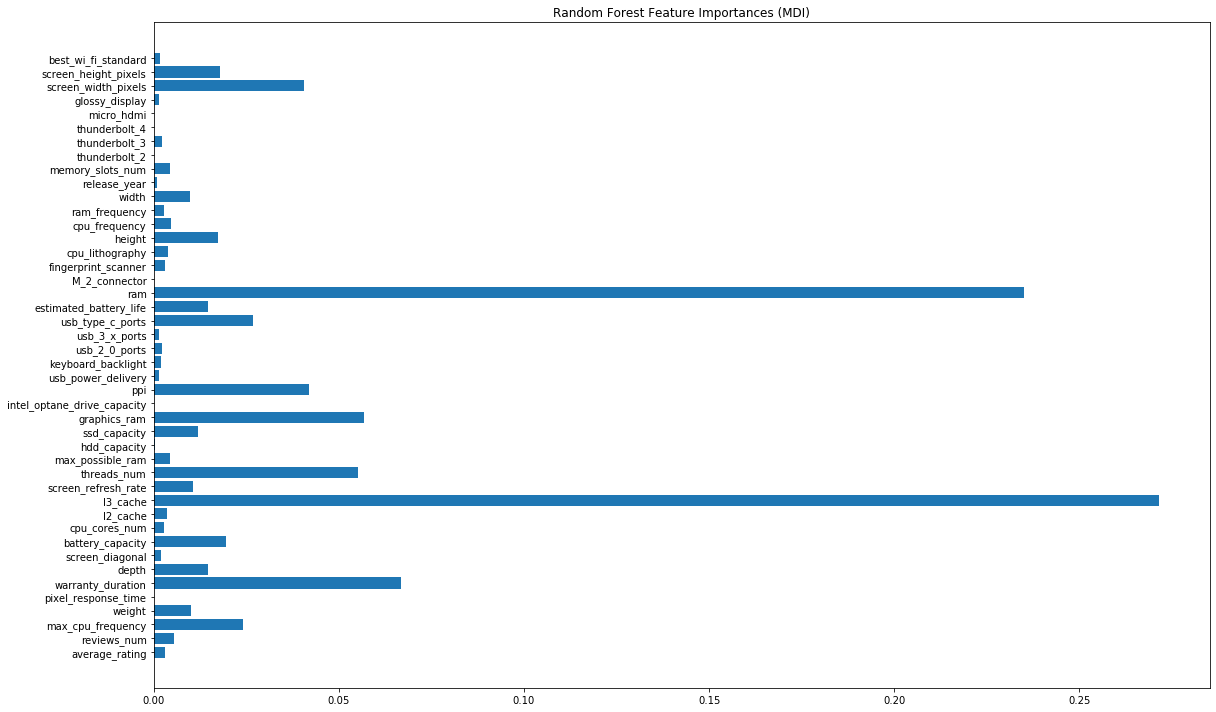

In [490]:
# y_ticks = np.arange(0, len(X_test.columns))
# fig, ax = plt.subplots(figsize = (17, 10))
# ax.barh(y_ticks, reg.feature_importances_)
# ax.set_yticklabels(X_test.columns)
# ax.set_yticks(y_ticks)
# ax.set_title("Random Forest Feature Importances (MDI)")
# fig.tight_layout()
# plt.show()

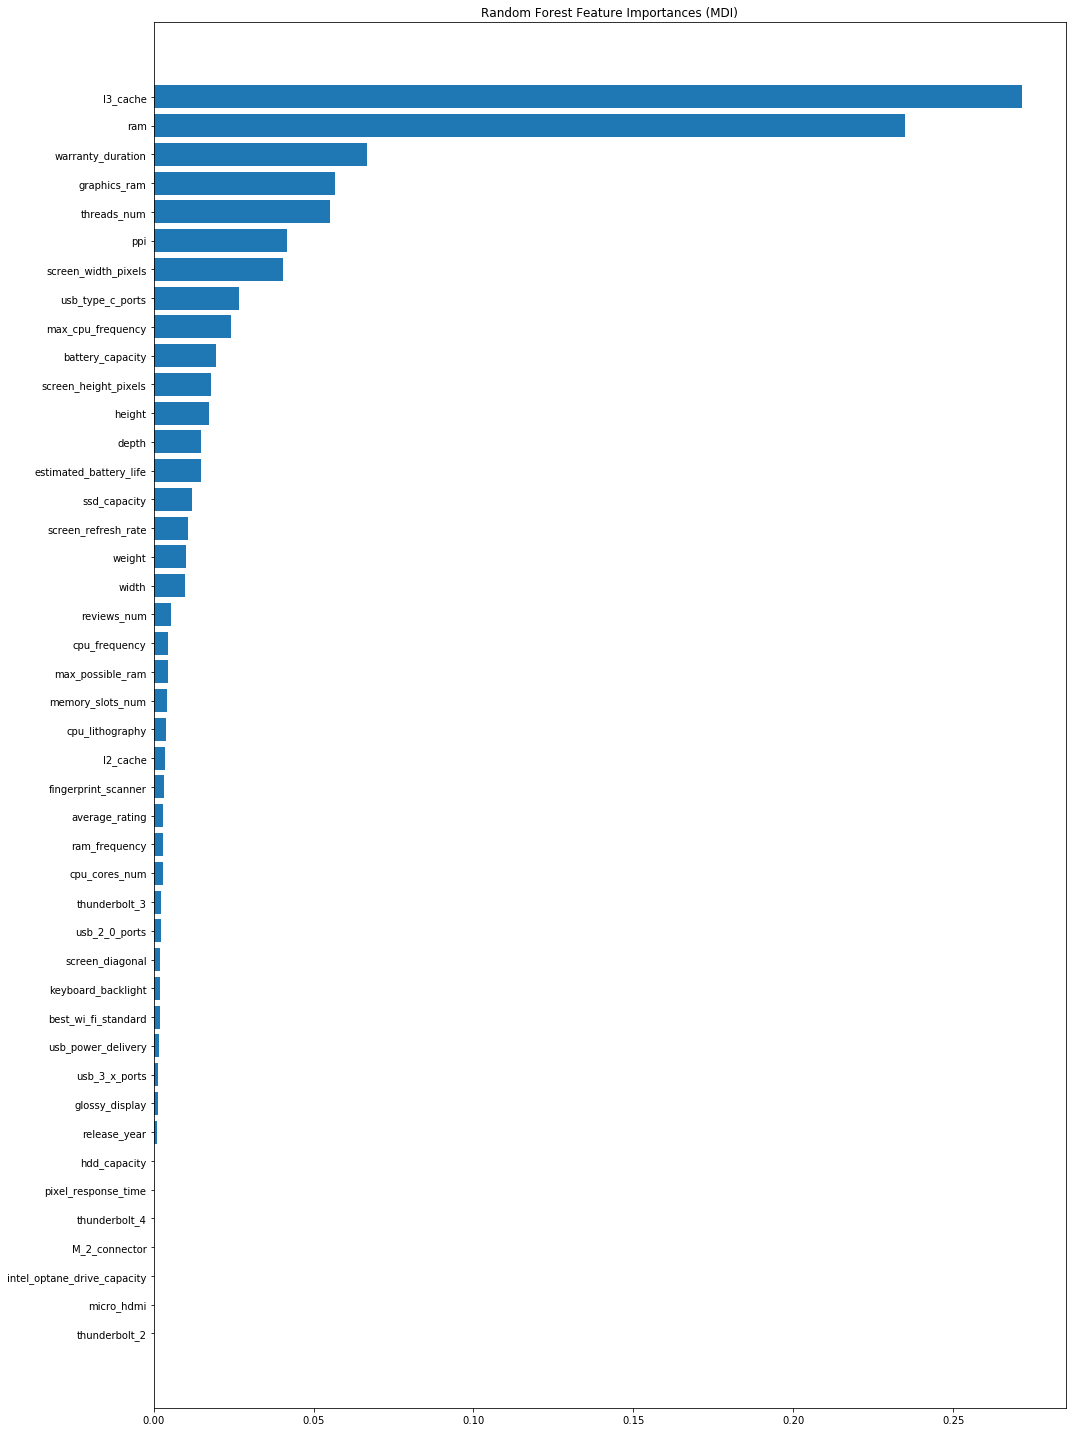

In [497]:
def get_feature_importances(random_forest_model):
    tree_feature_importances = random_forest_model.feature_importances_
    
    sorted_idx = tree_feature_importances.argsort()

    y_ticks = np.arange(0, len(X_test.columns))
    fig, ax = plt.subplots(figsize = (15, 20))
    ax.barh(y_ticks, tree_feature_importances[sorted_idx])
    ax.set_yticklabels(X_test.columns[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title("Random Forest Feature Importances (MDI)")
    fig.tight_layout()
    plt.show()
    
get_feature_importances(reg)

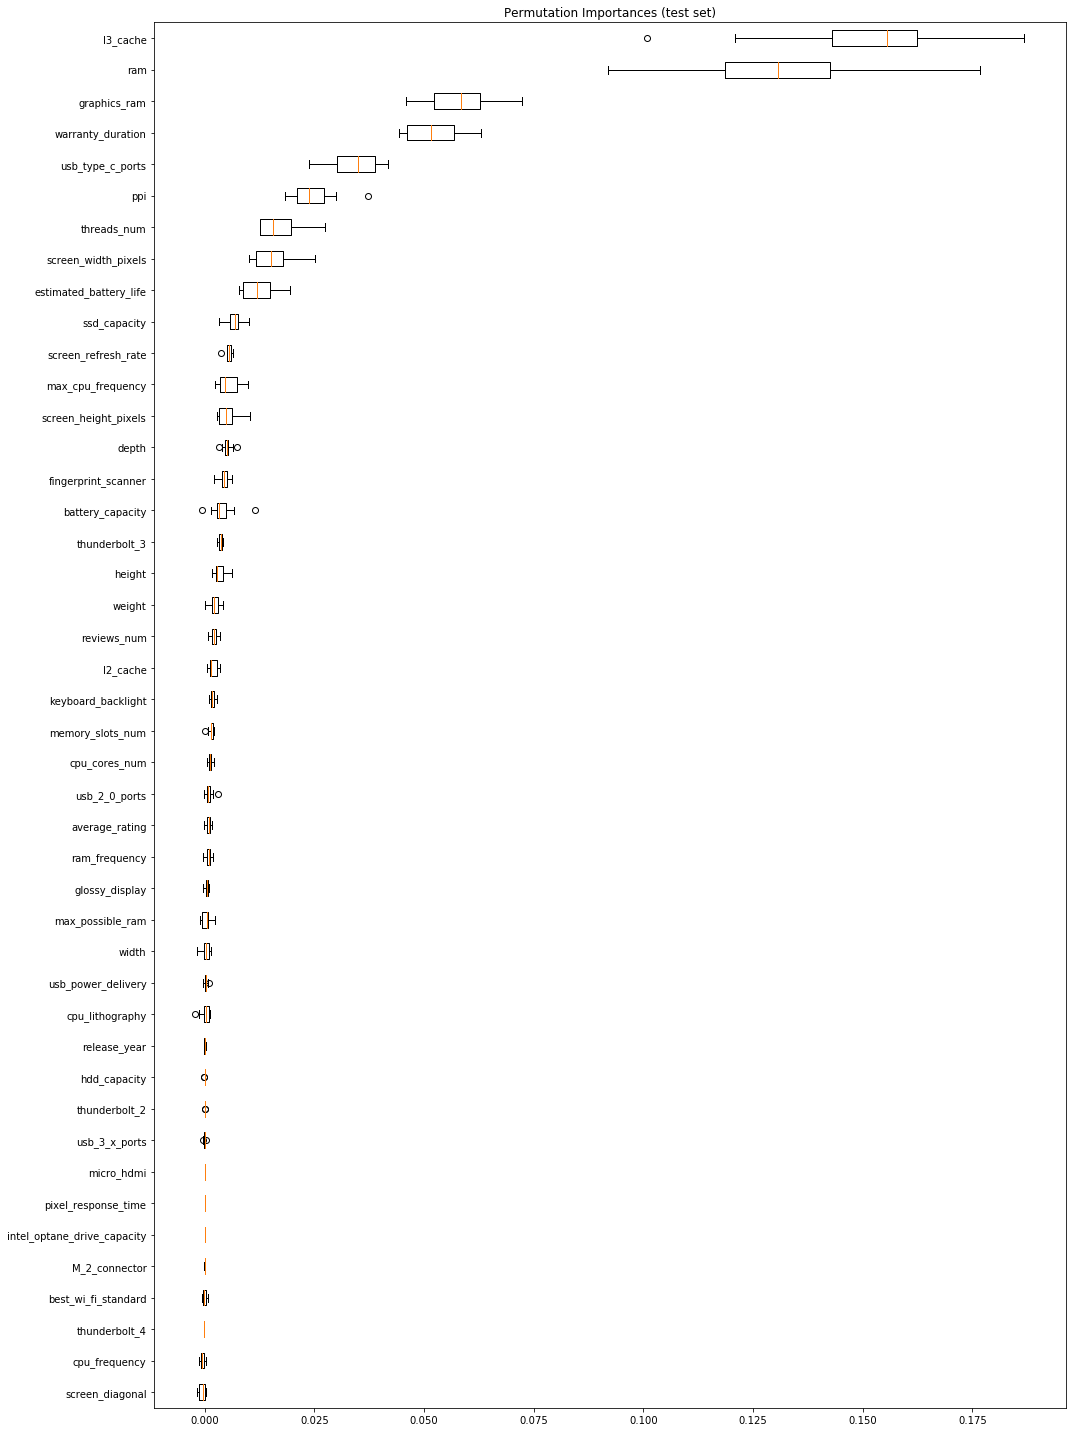

In [499]:
from sklearn.inspection import permutation_importance

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (15, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [503]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(reg, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1705 ± 0.0282,l3_cache
0.1400 ± 0.0216,ram
0.0586 ± 0.0082,warranty_duration
0.0575 ± 0.0106,graphics_ram
0.0270 ± 0.0048,usb_type_c_ports
0.0256 ± 0.0048,threads_num
0.0209 ± 0.0017,ppi
0.0170 ± 0.0037,estimated_battery_life
0.0153 ± 0.0035,battery_capacity
0.0149 ± 0.0024,screen_width_pixels


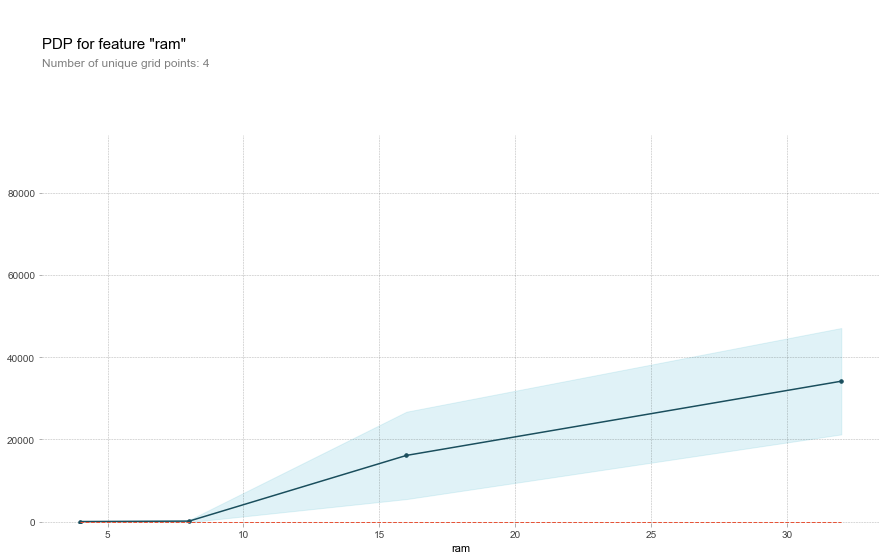

In [507]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=reg, dataset=X_test, model_features=X_test.columns.tolist(), feature='ram')

# plot it
pdp.pdp_plot(pdp_goals, 'ram')
plt.show()

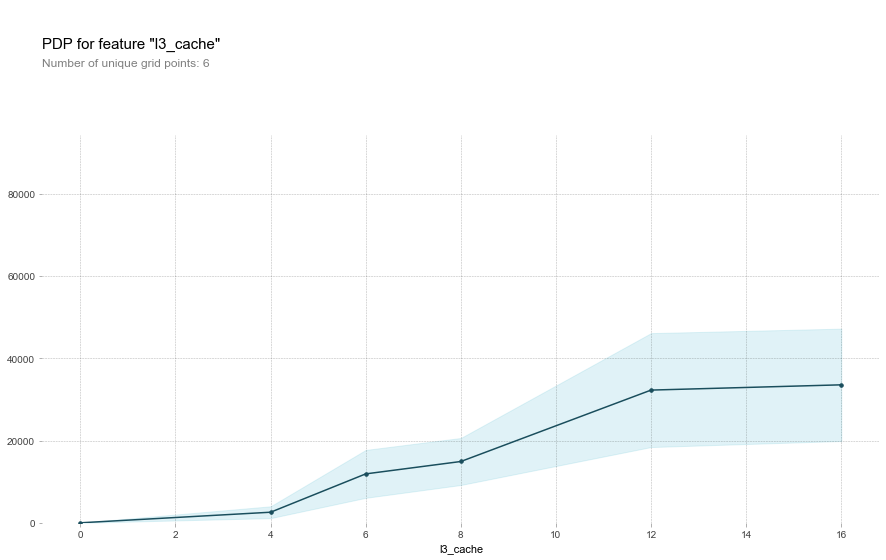

In [508]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=reg, dataset=X_test, model_features=X_test.columns.tolist(), feature='l3_cache')

# plot it
pdp.pdp_plot(pdp_goals, 'l3_cache')
plt.show()

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

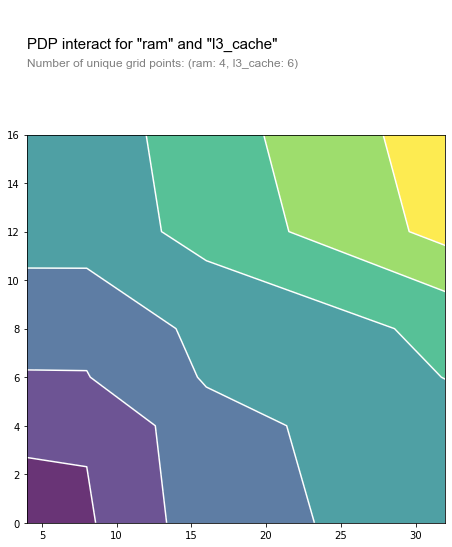

In [509]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['ram', 'l3_cache']
inter1  =  pdp.pdp_interact(model=reg, dataset=X_test, model_features=X_test.columns.tolist(), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

In [512]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]

In [514]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(reg)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [516]:
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
reg.predict(data_for_prediction_array)

array([115355.])

In [520]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [535]:
import shap

explainer = shap.KernelExplainer(reg.predict, X_train)

Using 396 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [536]:
reg_shap_values = explainer.shap_values(X_test, nsamples=100)

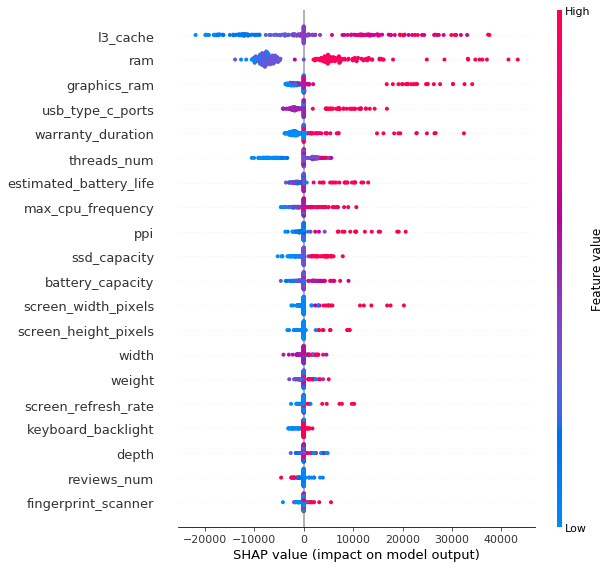

In [537]:
shap.summary_plot(reg_shap_values, X_test)

In [532]:
# load JS visualization code to notebook
shap.initjs()

In [547]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value, reg_shap_values[9,:], X_test.iloc[9,:])

In [550]:
explainer.

85876.37472342473

In [554]:
shap.force_plot(y_test.iloc[12], reg_shap_values[11,:], X_test.iloc[12,:])

In [477]:
data.columns.values

array(['average_rating', 'price', 'reviews_num', 'max_cpu_frequency',
       'cpu_architecture', 'web_camera', 'weight', 'ethernet_adapter',
       'pixel_response_time', 'microphone', 'warranty_duration', 'depth',
       'screen_diagonal', 'battery_capacity', 'gaming_laptop',
       'kensington_lock', 'cpu_cores_num', 'l2_cache', 'l3_cache',
       'cpu_family', 'screen_refresh_rate', 'threads_num',
       'max_possible_ram', 'integrated_graphics_card_model',
       'dedicated_graphics_card_model', 'cpu_model',
       'screen_resolution_name', 'hdd_capacity', 'ssd_capacity',
       'graphics_ram', 'intel_optane_drive_capacity', 'os',
       'optical_disc_drive', 'ppi', 'usb_power_delivery',
       'keyboard_backlight', 'usb_2_0_ports', 'usb_3_x_ports',
       'usb_type_c_ports', 'estimated_battery_life', 'gpu_manufacturer',
       'cpu_manufacturer', 'ram', 'M_2_connector', 'sound_system',
       'touch_screen', 'fingerprint_scanner', 'cpu_lithography',
       'graphics_ram_type', 'ra

In [529]:
data.loc[146 + 1][['model_name', 'price', 'max_cpu_frequency', 'average_rating', 'reviews_num']]

model_name           Swift 3 SF314-58G-57N7
price                                 49999
max_cpu_frequency                       4.2
average_rating                          3.8
reviews_num                               5
Name: 147, dtype: object

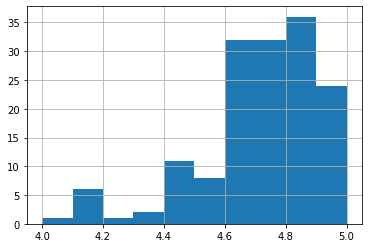

In [531]:
data[data.reviews_num > 10].average_rating.hist()

In [504]:
data.loc[136545].ssd_capacity

256.0

In [489]:
data.loc[438].model_name

'ENVY x360 Convert 15-ed1005ur'

In [ ]:
258    1.891293
437 

In [484]:
data

,average_rating,price,reviews_num,max_cpu_frequency,cpu_architecture,web_camera,weight,ethernet_adapter,pixel_response_time,microphone,...,micro_sdhc,micro_sdxc,glossy_display,screen_width_pixels,screen_height_pixels,hdd_increased_speed,best_wi_fi_standard,li_ion_battery_type,ultrabook,touch_numeric_keypad
0,1.0,17999.0,1.0,2.2,GoldMont,True,0.935,False,30.0,True,...,False,False,0.0,1280,800,False,4,True,False,False
1,4.2,24999.0,17.0,2.8,Goldmont Plus,True,1.050,False,NaN,True,...,True,True,0.0,1366,768,False,5,True,False,False
2,4.7,24999.0,3.0,2.8,Goldmont Plus,True,1.050,False,NaN,True,...,True,True,0.0,1366,768,False,5,False,False,False
3,4.6,24999.0,9.0,2.8,Goldmont Plus,True,1.050,False,NaN,True,...,True,True,0.0,1366,768,False,5,True,False,False
4,3.8,28999.0,9.0,2.6,Excavator,True,2.000,False,NaN,True,...,True,True,0.0,1366,768,False,5,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,NaN,313999.0,NaN,4.5,Comet Lake,True,2.100,True,NaN,True,...,False,False,0.0,3840,2160,False,6,True,False,False
725,3.0,349999.0,2.0,4.5,Comet Lake,True,2.100,True,NaN,True,...,False,False,0.0,3840,2160,False,5,True,False,False
726,NaN,379999.0,NaN,5.0,Comet Lake,True,2.540,True,NaN,True,...,False,False,0.0,3840,2160,False,6,True,False,False
727,NaN,380999.0,NaN,4.5,Comet Lake,True,2.100,True,NaN,True,...,False,False,0.0,3840,2160,False,5,True,False,False
